In [0]:
import numpy as np
import sklearn
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import ensemble,tree,linear_model
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler, StandardScaler
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier,GradientBoostingRegressor)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.cross_validation import KFold
import tensorflow as tf
import warnings
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
%reload_ext autoreload
%autoreload 2
%matplotlib inline
warnings.filterwarnings('ignore')

pd.options.display.max_columns=99

# Input data

#### The original input data contains **8717 objects and 1892 features**, but at the same time contains so many missing data. Before looking the unique values in each column, I will drop the constant values that is not useful and will make the Input_Data lighter

In [0]:
Input_Data = pd.read_csv('TADPOLE_InputData.csv')

# We will takeoff all columns where we have a unique value (constants)
# It is useful because this columns don't give us none information
discovering_consts = [col for col in Input_Data.columns if Input_Data[col].nunique() == 1]

# printing the total of columns dropped and the name of columns 
print("Columns with just one value: ", len(discovering_consts), "columns")
print("Name of constant columns: \n", discovering_consts)

Input_Data = Input_Data.drop(columns=discovering_consts,axis=1)

Columns with just one value:  166 columns
Name of constant columns: 
 ['FLDSTRENG_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16', 'BASETP8_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16', 'FLDSTRENG_UCSFFSX_11_02_15_UCSFFSX51_08_01_16', 'HIPPR01_BAIPETNMRC_09_12_16', 'LINGUALL01_BAIPETNMRC_09_12_16', 'LINGUALR01_BAIPETNMRC_09_12_16', 'CINGPSTR01_BAIPETNMRC_09_12_16', 'FRTINFL01_BAIPETNMRC_09_12_16', 'FRTINFR01_BAIPETNMRC_09_12_16', 'PARISUPL01_BAIPETNMRC_09_12_16', 'PARISUPR01_BAIPETNMRC_09_12_16', 'INSULAL01_BAIPETNMRC_09_12_16', 'INSULAR01_BAIPETNMRC_09_12_16', 'CINGANTL01_BAIPETNMRC_09_12_16', 'CINGANTR01_BAIPETNMRC_09_12_16', 'CINGMIDL01_BAIPETNMRC_09_12_16', 'CINGMIDR01_BAIPETNMRC_09_12_16', 'TMPSUPL01_BAIPETNMRC_09_12_16', 'TMPSUPR01_BAIPETNMRC_09_12_16', 'TMPINFL01_BAIPETNMRC_09_12_16', 'CINGPSTR02_BAIPETNMRC_09_12_16', 'PARIINFL02_BAIPETNMRC_09_12_16', 'INSULAL02_BAIPETNMRC_09_12_16', 'FRTINFL02_BAIPETNMRC_09_12_16', 'FRTINFR02_BAIPETNMRC_09_12_16', 'OCCMIDR02_BAIPETNMRC_09_12_16', 'FRTMIDOL0

Wow, 166 columns were dropped, but we still have 1892-166=1726 features. So, I think we could drop data by analyzing the missing values statistic.

In [0]:
# statistic function for missing data
def missing_values(data):
    total = data.isnull().sum().sort_values(ascending = False) # getting the sum of null values and ordering
    percent = (data.isnull().sum() / data.isnull().count() * 100 ).sort_values(ascending = False) #getting the percent and order of null
    df = pd.concat([total, percent], axis=1, keys=['Total', 'Percent']) # Concatenating the total and percent
    if len(df[df['Total'] == 0].index.values)!=0:
        print('Columns no data missing:',df[df['Total'] == 0].index.values)
        
    print("Total columns at least one Values: ")
    print (df[~(df['Total'] == 0)]) # Returning values of nulls different of 0
    most_nan= [idx for idx in df[~(df['Total'] == 0)].index if df[~(df['Total'] == 0)].loc[idx,'Percent']>60]
    print(str(len(most_nan)) + ' columns containing more than 60% missing data')
    return most_nan

most_nan = missing_values(Input_Data)

Columns no data missing: ['EXAMDATE']
Total columns at least one Values: 
                                                    Total     Percent
CTX_LH_MIDDLETEMPORAL_SIZE_UCBERKELEYAV1451_10_...   8717  100.000000
CTX_RH_PARSORBITALIS_SIZE_UCBERKELEYAV1451_10_1...   8717  100.000000
CTX_RH_POSTCENTRAL_SIZE_UCBERKELEYAV1451_10_17_16    8717  100.000000
CTX_RH_POSTCENTRAL_UCBERKELEYAV1451_10_17_16         8717  100.000000
CTX_RH_PERICALCARINE_SIZE_UCBERKELEYAV1451_10_1...   8717  100.000000
CTX_RH_PERICALCARINE_UCBERKELEYAV1451_10_17_16       8717  100.000000
CTX_RH_PARSTRIANGULARIS_SIZE_UCBERKELEYAV1451_1...   8717  100.000000
CTX_RH_PARSTRIANGULARIS_UCBERKELEYAV1451_10_17_16    8717  100.000000
CTX_RH_PARSORBITALIS_UCBERKELEYAV1451_10_17_16       8717  100.000000
CTX_RH_POSTERIORCINGULATE_SIZE_UCBERKELEYAV1451...   8717  100.000000
CTX_RH_PARSOPERCULARIS_SIZE_UCBERKELEYAV1451_10...   8717  100.000000
CTX_RH_PARSOPERCULARIS_UCBERKELEYAV1451_10_17_16     8717  100.000000
CTX_RH_PARAHIPPO

In [0]:
Input_Data[Input_Data['EXAMDATE_bl'].isnull()]

,PTID_Key,EXAMDATE,DX_bl,DXCHANGE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,PIB,AV45,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,DX,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,...,AD_ACR_L_DTIROI_04_30_14,AD_ACR_R_DTIROI_04_30_14,AD_SCR_L_DTIROI_04_30_14,AD_SCR_R_DTIROI_04_30_14,AD_PCR_L_DTIROI_04_30_14,AD_PCR_R_DTIROI_04_30_14,AD_CGC_L_DTIROI_04_30_14,AD_CGC_R_DTIROI_04_30_14,AD_CGH_L_DTIROI_04_30_14,AD_CGH_R_DTIROI_04_30_14,AD_FX_ST_L_DTIROI_04_30_14,AD_FX_ST_R_DTIROI_04_30_14,AD_SLF_L_DTIROI_04_30_14,AD_SLF_R_DTIROI_04_30_14,AD_SFO_L_DTIROI_04_30_14,AD_SFO_R_DTIROI_04_30_14,AD_IFO_L_DTIROI_04_30_14,AD_IFO_R_DTIROI_04_30_14,AD_SS_L_DTIROI_04_30_14,AD_SS_R_DTIROI_04_30_14,AD_EC_L_DTIROI_04_30_14,AD_EC_R_DTIROI_04_30_14,AD_UNC_L_DTIROI_04_30_14,AD_UNC_R_DTIROI_04_30_14,AD_FX_L_DTIROI_04_30_14,AD_FX_R_DTIROI_04_30_14,AD_GCC_L_DTIROI_04_30_14,AD_GCC_R_DTIROI_04_30_14,AD_BCC_L_DTIROI_04_30_14,AD_BCC_R_DTIROI_04_30_14,AD_SCC_L_DTIROI_04_30_14,AD_SCC_R_DTIROI_04_30_14,AD_RLIC_L_DTIROI_04_30_14,AD_RLIC_R_DTIROI_04_30_14,AD_TAP_L_DTIROI_04_30_14,AD_TAP_R_DTIROI_04_30_14,AD_SUMGCC_DTIROI_04_30_14,AD_SUMBCC_DTIROI_04_30_14,AD_SUMSCC_DTIROI_04_30_14,AD_SUMCC_DTIROI_04_30_14,AD_SUMFX_DTIROI_04_30_14,update_stamp_DTIROI_04_30_14,EXAMDATE_UPENNBIOMK9_04_19_17,PHASE_UPENNBIOMK9_04_19_17,RUNDATE_UPENNBIOMK9_04_19_17,ABETA_UPENNBIOMK9_04_19_17,TAU_UPENNBIOMK9_04_19_17,PTAU_UPENNBIOMK9_04_19_17,COMMENT_UPENNBIOMK9_04_19_17
3503,NaN,807,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


*  We can find from above that just one column-'EXAMDATE' has no missing data, and PTID_Key and EXAMDATE_bl miss two/one data;
*  1010 columns containing more than 60% missing data, so drop those columns and still 1726-1010=716 featues;
*  we can find some unknown columns which names are very long, so ignoring those columns and just pick the other features (50);

In [0]:
# drop the missing data in EXAMDATE_bl and PTID_key
# when the EXAMDATE_bl miss, the PTID_Key also miss
Input_Data = Input_Data.drop(index=Input_Data[Input_Data['PTID_Key'].isnull()].index.values, axis=0) 

Input_Data = Input_Data.drop(columns=most_nan,axis=1)
print(Input_Data.columns.values)

['PTID_Key' 'EXAMDATE' 'DX_bl' 'DXCHANGE' 'AGE' 'PTGENDER' 'PTEDUCAT'
 'PTETHCAT' 'PTRACCAT' 'PTMARRY' 'APOE4' 'CDRSB' 'ADAS11' 'ADAS13' 'MMSE'
 'RAVLT_immediate' 'RAVLT_learning' 'RAVLT_forgetting'
 'RAVLT_perc_forgetting' 'FAQ' 'Ventricles' 'Hippocampus' 'WholeBrain'
 'Entorhinal' 'Fusiform' 'MidTemp' 'ICV' 'DX' 'EXAMDATE_bl' 'CDRSB_bl'
 'ADAS11_bl' 'ADAS13_bl' 'MMSE_bl' 'RAVLT_immediate_bl'
 'RAVLT_learning_bl' 'RAVLT_forgetting_bl' 'RAVLT_perc_forgetting_bl'
 'FAQ_bl' 'Ventricles_bl' 'Hippocampus_bl' 'WholeBrain_bl' 'Entorhinal_bl'
 'Fusiform_bl' 'MidTemp_bl' 'ICV_bl' 'FDG_bl' 'Years_bl' 'Month_bl'
 'Month' 'M' 'EXAMDATE_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16'
 'VERSION_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16'
 'LONISID_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16'
 'LONIUID_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16'
 'IMAGEUID_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16'
 'RUNDATE_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16'
 'STATUS_UCSFFSL_02_01_16_UCSFFSL51ALL_08_01_16'
 'ST101SV_UCSFFSL_02_01_16_

In [0]:
pick_columns = ['PTID_Key', 'EXAMDATE', 'DX_bl', 'DXCHANGE', 'AGE', 'PTGENDER', 'PTEDUCAT',
 'PTETHCAT', 'PTRACCAT', 'PTMARRY', 'APOE4', 'CDRSB', 'ADAS11', 'ADAS13', 'MMSE',
 'RAVLT_immediate', 'RAVLT_learning', 'RAVLT_forgetting',
 'RAVLT_perc_forgetting', 'FAQ', 'Ventricles', 'Hippocampus', 'WholeBrain',
 'Entorhinal', 'Fusiform', 'MidTemp', 'ICV', 'DX', 'EXAMDATE_bl', 'CDRSB_bl',
 'ADAS11_bl', 'ADAS13_bl', 'MMSE_bl', 'RAVLT_immediate_bl',
 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', 'RAVLT_perc_forgetting_bl',
 'FAQ_bl', 'Ventricles_bl', 'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl',
 'Fusiform_bl', 'MidTemp_bl', 'ICV_bl', 'FDG_bl', 'Years_bl', 'Month_bl',
 'Month', 'M']
Input_Data = Input_Data[pick_columns]

*  Continuing to analyze the rest features, we can find some maybe non-useful features, such as 'PTGENDER', 'PTEDUCAT', 'PTETHCAT', 'PTMARRY', etc; some features containing same information, such as 'RAVLT_learning_bl', 'RAVLT_forgetting_bl', etc. So dropping them.

In [0]:
discovering_drop = ['DX','EXAMDATE','PTGENDER', 'PTEDUCAT', 'PTRACCAT','PTETHCAT', 'PTMARRY','RAVLT_learning', 
                    'RAVLT_forgetting', 'RAVLT_perc_forgetting', 'RAVLT_learning_bl', 'RAVLT_forgetting_bl',
                   'RAVLT_perc_forgetting_bl','Years_bl','Month_bl','M','FDG_bl']

Input_Data = Input_Data.drop(columns=discovering_drop,axis=1)

*  Look the statistic of missing values in the rest data   
*  We have 35 columns now
*  Our target labels are Diag(CN_Diag, MCI_Diag, AD_Diag), ASAD13, Ventricels_Norm, MMSE

In [0]:
_ = missing_values(Input_Data)
print("*"*60)
print(Input_Data.info())

# transfer the EXAMDATE_bl into pd.to_datetime
Input_Data['EXAMDATE_bl'] = pd.to_datetime(Input_Data['EXAMDATE_bl'])

Columns no data missing: ['DX_bl' 'AGE' 'Month' 'EXAMDATE_bl' 'CDRSB_bl' 'MMSE_bl' 'PTID_Key']
Total columns at least one Values: 
                    Total    Percent
MidTemp              3412  39.150889
Fusiform             3412  39.150889
Entorhinal           3412  39.150889
Hippocampus          3355  38.496845
Ventricles           2566  29.443488
ADAS13               2486  28.525531
RAVLT_immediate      2474  28.387837
CDRSB                2427  27.848537
ADAS11               2423  27.802639
WholeBrain           2418  27.745267
MMSE                 2412  27.676420
FAQ                  2409  27.641997
DXCHANGE             2399  27.527252
ICV                  2290  26.276535
MidTemp_bl           1367  15.685600
Fusiform_bl          1367  15.685600
Entorhinal_bl        1367  15.685600
Hippocampus_bl       1321  15.157774
Ventricles_bl         265   3.040734
WholeBrain_bl         149   1.709696
ADAS13_bl              57   0.654045
ICV_bl                 50   0.573723
FAQ_bl            

In [0]:
# look how many different values 'DX_bl' have
print('Different DX_bl values:',np.unique(Input_Data['DX_bl'].values))

# map those values into numbers
DXbl_mapping = {"CN": 0, "EMCI": 1, "LMCI": 2, "SMC": 3,"AD": 4}
Input_Data['DX_bl'] = Input_Data['DX_bl'].map(DXbl_mapping)

print('*'*60)
print('Mapped values:',np.unique(Input_Data['DX_bl'].values))

Different DX_bl values: ['AD' 'CN' 'EMCI' 'LMCI' 'SMC']
************************************************************
Mapped values: [0 1 2 3 4]


In [0]:
Input_Data = Input_Data.reset_index(drop=True)

## Fill the missing data
* **First fill the baseline features** 
 * **MidTemp_bl**------------**1367**----**15.685600**
 * **Fusiform_bl**------------**1367**----**15.685600**
 * **Entorhinal_bl**----------**1367**----**15.685600**
 * **Hippocampus_bl**------**1321**----**15.157774**
 * **Ventricles_bl**------------**265**-----**3.040734**
 * **WholeBrain_bl**----------**149**-----**1.709696**
 * **ADAS13_bl**---------------**57**-----**0.654045**
 * **ICV_bl**---------------------**50**-----**0.573723**
 * **FAQ_bl**--------------------**36**-----**0.413081**
 * **RAVLT_immediate_bl**---**30**-----**0.344234**
 * **ADAS11_bl**----------------**7**------**0.080321**
 * they are all baseline results, so using same DX_bl objects data to fill
  * find the baseline results first
  * then we know the DX_bl has 5 different values, calculating mean for each DX_bl value.
* **Fill the others feature**
 * use the mean value of same 'DX_bl' and diagnosis features

In [0]:
fill_features = ['MidTemp_bl','Fusiform_bl','Entorhinal_bl','Hippocampus_bl','Ventricles_bl',
                 'WholeBrain_bl','ADAS13_bl','ICV_bl','FAQ_bl','RAVLT_immediate_bl','ADAS11_bl']

for feature in fill_features:
    fill_value0 = Input_Data[Input_Data['DX_bl']==0][feature].mean(axis=0)
    idx0 = Input_Data[(Input_Data['DX_bl']==0) & (Input_Data[feature].isnull())].index.values
    for ix0 in idx0:
        Input_Data.loc[ix0,feature] = fill_value0
    
    fill_value1 = Input_Data[Input_Data['DX_bl']==1][feature].mean(axis=0)
    idx1 = Input_Data[(Input_Data['DX_bl']==1) & (Input_Data[feature].isnull())].index.values
    for ix1 in idx1:
        Input_Data.loc[ix1,feature] = fill_value1
    
    fill_value2 = Input_Data[Input_Data['DX_bl']==2][feature].mean(axis=0)
    idx2 = Input_Data[(Input_Data['DX_bl']==2) & (Input_Data[feature].isnull())].index.values
    for ix2 in idx2:
        Input_Data.loc[ix2,feature] = fill_value2
    
    fill_value3 = Input_Data[Input_Data['DX_bl']==3][feature].mean(axis=0)
    idx3 = Input_Data[(Input_Data['DX_bl']==3) & (Input_Data[feature].isnull())].index.values
    for ix3 in idx3:
        Input_Data.loc[ix3,feature] = fill_value3   
    
    fill_value4 = Input_Data[Input_Data['DX_bl']==4][feature].mean(axis=0)
    idx4 = Input_Data[(Input_Data['DX_bl']==4) & (Input_Data[feature].isnull())].index.values
    for ix4 in idx4:
        Input_Data.loc[ix4,feature] = fill_value4

* **Find if there is missing data in the DXHCANGE of baseline date**

In [0]:
Input_Data[(Input_Data['Month']==0) & (Input_Data['DXCHANGE'].isnull())]

,PTID_Key,DX_bl,DXCHANGE,AGE,APOE4,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,MMSE_bl,RAVLT_immediate_bl,FAQ_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,Month
3502,1039.0,1,NaN,55.5,NaN,1.5,4.0,8.0,28.0,29.0,NaN,50091.0,8526.0,1231830.0,5168.0,20059.0,20669.0,1706520.0,2011-07-11,1.5,4.000000,8.000000,28.0,29.000000,1.966549,50091.000000,8526.000000,1.231830e+06,5168.000000,20059.000000,20669.000000,1.706520e+06,0.0
4274,542.0,1,NaN,62.1,NaN,0.5,NaN,NaN,29.0,43.0,0.0,12466.0,7228.0,1044830.0,3967.0,21114.0,21609.0,1268820.0,2012-05-09,0.5,7.846831,12.466549,29.0,43.000000,0.000000,12466.000000,7228.000000,1.044830e+06,3967.000000,21114.000000,21609.000000,1.268820e+06,0.0
4350,1538.0,2,NaN,76.0,NaN,2.5,NaN,NaN,25.0,NaN,NaN,63260.0,NaN,1101050.0,3001.0,20384.0,18764.0,1657690.0,2012-04-06,2.5,11.253810,18.268291,25.0,31.648618,3.757248,63260.000000,6473.577833,1.101050e+06,3001.000000,20384.000000,18764.000000,1.657690e+06,0.0
4670,666.0,4,NaN,71.8,NaN,4.0,14.0,25.0,25.0,22.0,8.0,17294.0,NaN,927188.0,2099.0,14117.0,15130.0,1258270.0,2012-10-30,4.0,14.000000,25.000000,25.0,22.000000,8.000000,17294.000000,5690.047619,9.271880e+05,2099.000000,14117.000000,15130.000000,1.258270e+06,0.0
8462,1199.0,0,NaN,68.1,NaN,0.0,6.0,10.0,30.0,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2012-03-06,0.0,6.000000,10.000000,30.0,60.000000,0.151449,34956.187013,7284.888934,1.019122e+06,3816.320611,17412.810767,20026.775412,1.530738e+06,0.0
8710,347.0,0,NaN,74.1,0.0,0.0,3.0,6.0,29.0,48.0,NaN,50196.0,6254.0,954172.0,2190.0,13415.0,18947.0,1415770.0,2011-10-25,0.0,3.000000,6.000000,29.0,48.000000,0.151449,50196.000000,6254.000000,9.541720e+05,2190.000000,13415.000000,18947.000000,1.415770e+06,0.0
8711,820.0,4,NaN,88.3,NaN,1.5,29.0,41.0,22.0,8.0,4.0,NaN,6480.0,NaN,NaN,NaN,NaN,1678780.0,2012-06-11,1.5,29.000000,41.000000,22.0,8.000000,4.000000,50055.090328,6480.000000,9.678773e+05,2777.714607,15233.778652,17091.211236,1.678780e+06,0.0


In [0]:
# firstly fill the DXCHANGE with Month=0, then every object has the DXCHANGE values in the first position
idx = Input_Data[(Input_Data['Month']==0) & (Input_Data['DXCHANGE'].isnull())].index.values
for ix in idx:
    DX_bl = Input_Data.loc[ix,'DX_bl']
    fill_value = Input_Data[(Input_Data['DX_bl']==DX_bl) & (Input_Data['Month']==0)]['DXCHANGE'].mode()[0]    
    Input_Data.loc[ix,'DXCHANGE'] = fill_value
    
Input_Data['DXCHANGE'].fillna(method='ffill',inplace=True)

* **use the mean of same values of DX_bl and DXCHANEG to fill missing data**

In [0]:
others_features = ['MidTemp','Fusiform','Entorhinal','Hippocampus','Ventricles',
                 'WholeBrain','ADAS13','ICV','FAQ','RAVLT_immediate','ADAS11','CDRSB','MMSE']

for feature in others_features:
    idx = Input_Data[Input_Data[feature].isnull()].index.values
    for ix in idx:
        DX_bl, DXCHANGE = Input_Data.loc[ix,'DX_bl'], Input_Data.loc[ix,'DXCHANGE']
        avg = Input_Data[(Input_Data['DX_bl']==DX_bl) & (Input_Data['DXCHANGE']==DXCHANGE)][feature].mean(axis=0)
        Input_Data.loc[ix,feature] = avg

for feature in others_features:
    Input_Data[feature].fillna(method='ffill',inplace=True)
        
# fill missing data in APOE4
idx = Input_Data[Input_Data['APOE4'].isnull()].index.values
for ix in idx:
    DX_bl, DXCHANGE = Input_Data.loc[ix,'DX_bl'], Input_Data.loc[ix,'DXCHANGE']
    mode = Input_Data[(Input_Data['DX_bl']==DX_bl) & (Input_Data['DXCHANGE']==DXCHANGE)]['APOE4'].mode()[0]
    Input_Data.loc[ix,'APOE4'] = mode

In [0]:
Input_Data = Input_Data.reset_index(drop=True)

Input_Data['PTID_Key'] = Input_Data['PTID_Key'].astype('int')
Input_Data['DX_bl'] = Input_Data['DX_bl'].astype('int')
Input_Data['DXCHANGE'] = Input_Data['DXCHANGE'].astype('int')
Input_Data['APOE4'] = Input_Data['APOE4'].astype('int')

In [0]:
Input_Data.head()

,PTID_Key,DX_bl,DXCHANGE,AGE,APOE4,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,FAQ,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,MMSE_bl,RAVLT_immediate_bl,FAQ_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,Month
0,400,0,1,74.3,0,0.0,10.67,18.67,28.0,44.0,0.0,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,2005-09-08,0.0,10.67,18.67,28.0,44.0,0.0,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,0.0
1,564,4,3,81.3,1,4.5,22.00,31.00,20.0,22.0,10.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,2005-09-12,4.5,22.00,31.00,20.0,22.0,10.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,0.0
2,564,4,3,81.3,1,6.0,19.00,30.00,24.0,19.0,12.0,88580.0,5446.0,1100060.0,2427.0,14400.0,16972.0,1906430.0,2005-09-12,4.5,22.00,31.00,20.0,22.0,10.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,6.0
3,564,4,3,81.3,1,3.5,24.00,35.00,17.0,31.0,17.0,90099.0,5157.0,1095640.0,1596.0,14617.0,17330.0,1903820.0,2005-09-12,4.5,22.00,31.00,20.0,22.0,10.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,12.0
4,564,4,3,81.3,1,8.0,25.67,37.67,19.0,23.0,14.0,97420.0,5139.0,1088560.0,1175.0,14033.0,16398.0,1903420.0,2005-09-12,4.5,22.00,31.00,20.0,22.0,10.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,24.0


** Normalize data**
* Ventricles, Hippocampus, WholeBrain, Entorhinal, Fusiform, MidTemp, ICV, Ventricles_bl, Hippocampus_bl, WholeBrain_bl, Entorhinal_bl, Fusiform_bl, MidTemp_bl, ICV_bl, ADAS11, RAVLT_immediate, FAQ, ADAS11_bl, RAVLT_immediate_bl, FAQ_bl					 	

In [0]:
Input_Data['Ventricles'] = Input_Data['Ventricles']/Input_Data['ICV']
Input_Data = Input_Data.rename(index=str,columns={'Ventricles':'Ventricles_Norm'})

Input_Data['Ventricles_bl'] = Input_Data['Ventricles_bl']/Input_Data['ICV_bl']

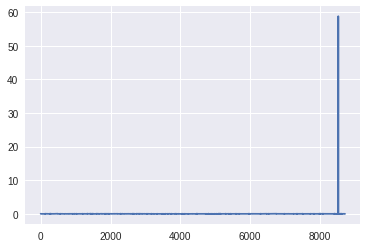

In [0]:
plt.figure()
plt.plot(range(Input_Data.shape[0]),Input_Data['Ventricles_Norm'].values)
plt.show()

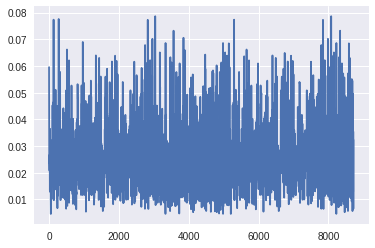

In [0]:
plt.figure()
plt.plot(range(Input_Data.shape[0]),Input_Data['Ventricles_bl'].values)
plt.show()

** Wow, very obvious outliers in Ventricles_Norm!!! JUST FIND THEM!!**

In [0]:
Input_Data[Input_Data['Ventricles_Norm']>=0.1]

,PTID_Key,DX_bl,DXCHANGE,AGE,APOE4,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,FAQ,Ventricles_Norm,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,MMSE_bl,RAVLT_immediate_bl,FAQ_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,Month
8521,492,2,2,65.4,0,1.807712,11.439319,18.449128,27.023023,30.726543,4.187531,58.759644,6855.0,882142.0,3334.612523,16712.085555,18945.048977,291.884,2012-05-22,1.5,8.0,16.0,30.0,34.0,1.0,0.027235,6473.577833,1.007912e+06,3353.711282,16702.757183,19004.715487,1.570263e+06,3.0


In [0]:
# remove it
Input_Data.drop(index=Input_Data[Input_Data['Ventricles_Norm']>=0.1].index.values,inplace=True)
Input_Data = Input_Data.reset_index(drop=True)

In [0]:
def normalize(feature):
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    Input_Data[feature] = scaler.fit_transform(Input_Data[feature].values.reshape(-1,1))
    return

In [0]:
norm_featrues = ['Month', 'AGE','CDRSB_bl','CDRSB','Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp', 
                'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl', 
                'MidTemp_bl', 'ICV_bl','ICV', 'ADAS11', 'RAVLT_immediate', 'FAQ', 'ADAS11_bl', 'RAVLT_immediate_bl', 'FAQ_bl']
for feature in norm_featrues:
    normalize(feature)

In [0]:
Input_Data.head()

,PTID_Key,DX_bl,DXCHANGE,AGE,APOE4,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,FAQ,Ventricles_Norm,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,MMSE_bl,RAVLT_immediate_bl,FAQ_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,Month
0,400,0,1,-0.004522,0,-0.831708,-0.122559,18.67,28.0,0.858919,-0.748044,0.059573,1.651114,2.319841,1.154736,-0.109106,3.394371,3.063957,2005-09-08,-0.881757,0.100985,18.67,28.0,0.700050,-0.632635,0.059573,1.455247,1.977902,0.93429,-0.195894,3.069730,2.662091,-0.947116
1,564,4,3,1.009858,1,0.979771,1.312707,31.00,20.0,-0.960278,0.633873,0.044046,-1.180248,1.295154,-2.279192,-0.560312,-0.170732,2.622286,2005-09-12,1.964385,2.017243,31.00,20.0,-1.150037,1.144934,0.044046,-1.301506,1.057670,-2.30097,-0.625854,-0.331124,2.274514,-0.947116
2,564,4,3,1.009858,1,1.583597,0.932672,30.00,24.0,-1.208350,0.910256,0.046464,-1.061062,0.989829,-1.363861,-1.034228,-0.714079,2.523831,2005-09-12,1.964385,2.017243,31.00,20.0,-1.150037,1.144934,0.044046,-1.301506,1.057670,-2.30097,-0.625854,-0.331124,2.274514,-0.656578
3,564,4,3,1.009858,1,0.577220,1.566063,35.00,17.0,-0.216061,1.601214,0.047325,-1.332280,0.944497,-2.559835,-0.941245,-0.579928,2.505810,2005-09-12,1.964385,2.017243,31.00,20.0,-1.150037,1.144934,0.044046,-1.301506,1.057670,-2.30097,-0.625854,-0.331124,2.274514,-0.366040
4,564,4,3,1.009858,1,2.388699,1.777616,37.67,19.0,-0.877587,1.186639,0.051182,-1.349172,0.871884,-3.165738,-1.191486,-0.929169,2.503049,2005-09-12,1.964385,2.017243,31.00,20.0,-1.150037,1.144934,0.044046,-1.301506,1.057670,-2.30097,-0.625854,-0.331124,2.274514,0.215036


**Pearson Correlation Heatmap**

let us generate some correlation plots of the features to see how related one feature is to the next.

* **all features except PTID_Key and EXAMDATE_bl**

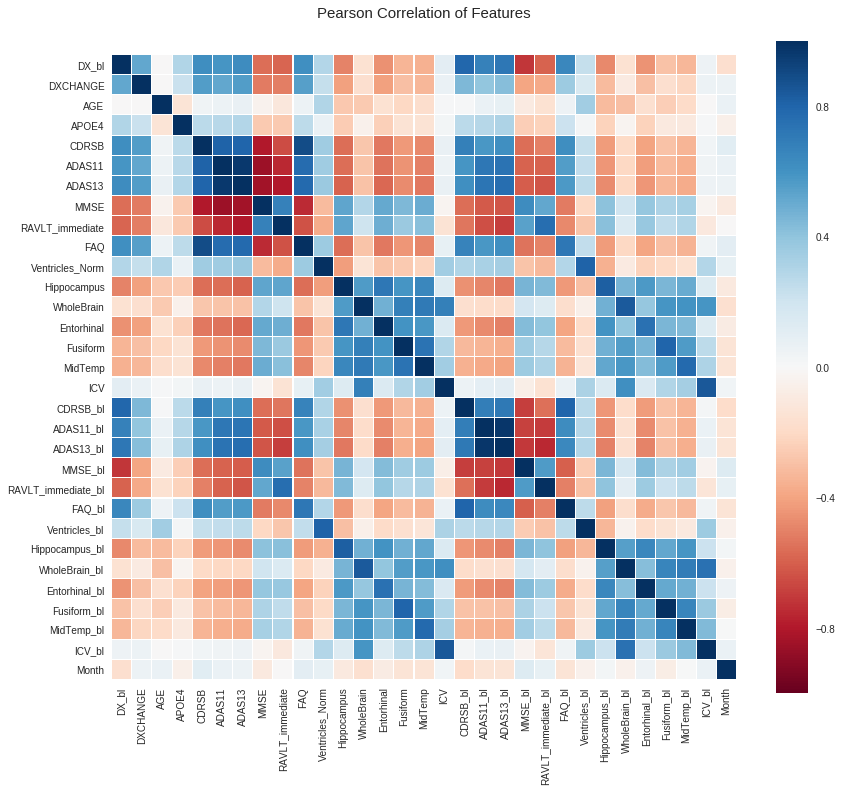

In [0]:
plot_df_data0 = Input_Data.drop(['PTID_Key','EXAMDATE_bl'],axis=1)
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(plot_df_data0.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=False)

* **all features except PTID_Key, EXAMDATE_bl, ADAS13, Ventricles_Norm and MMSE**

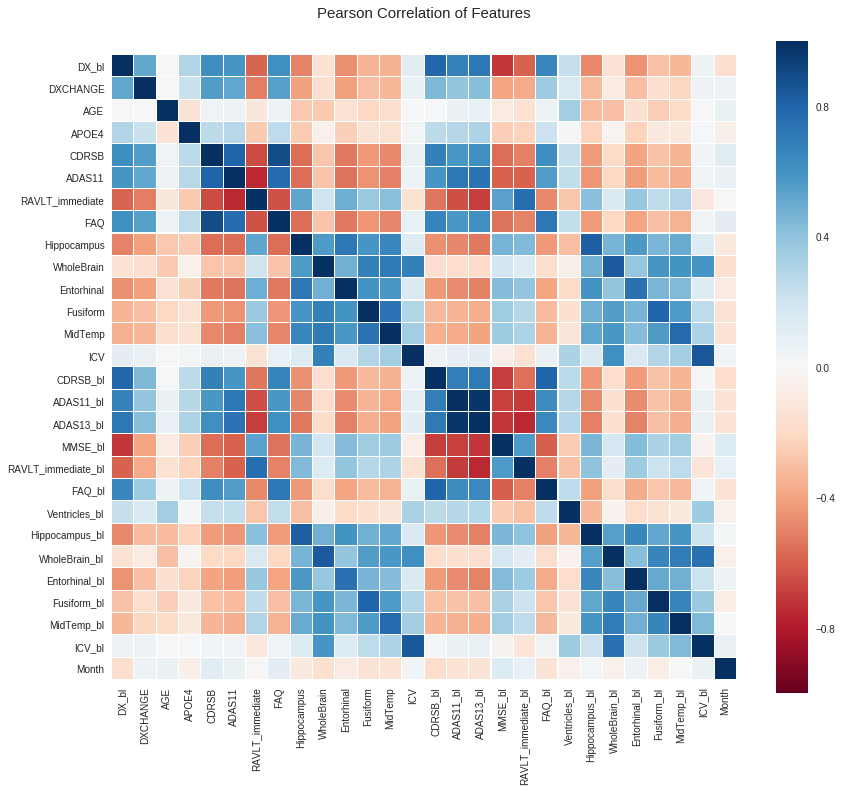

In [0]:
plot_df_data1 = Input_Data.drop(['PTID_Key','EXAMDATE_bl','ADAS13','Ventricles_Norm','MMSE'],axis=1)
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(plot_df_data1.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=False)

* **Selected features**

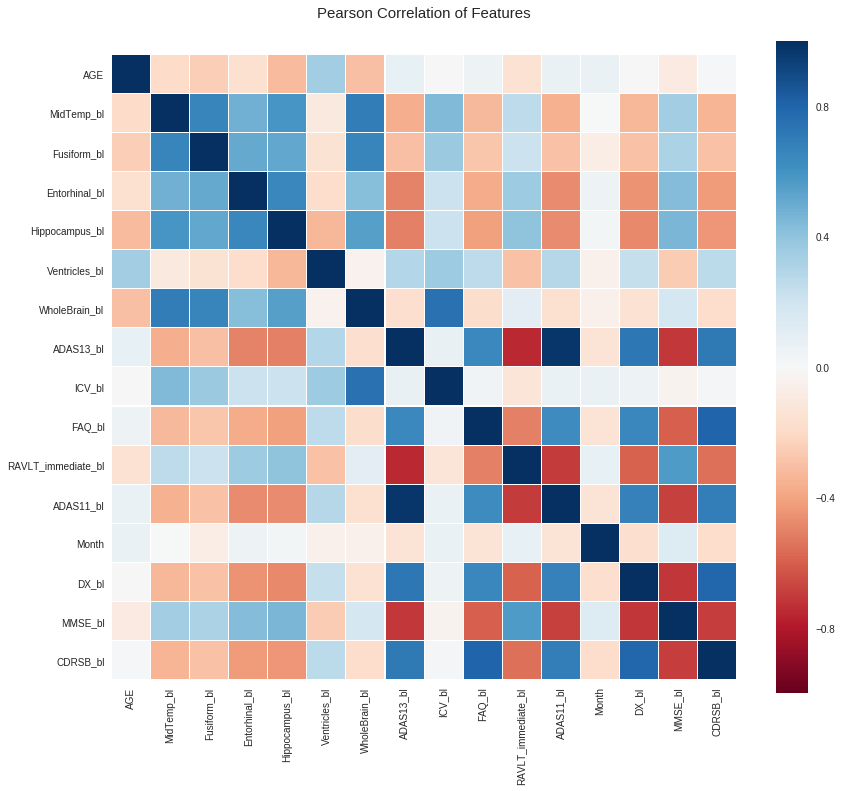

In [0]:
plot_df_data2 = Input_Data[['AGE','MidTemp_bl','Fusiform_bl','Entorhinal_bl','Hippocampus_bl','Ventricles_bl',
                 'WholeBrain_bl','ADAS13_bl','ICV_bl','FAQ_bl','RAVLT_immediate_bl',
                            'ADAS11_bl','Month','DX_bl','MMSE_bl','CDRSB_bl']]
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(plot_df_data2.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=False)

** Abobve all, 'MidTemp_bl','Fusiform_bl','Entorhinal_bl','Hippocampus_bl' are highly corrlated, so I just leave one of them- Hippocampus_bl; 'CDRSB_bl' and 'DX_bl' are highly correlated, so just leave DX_bl**

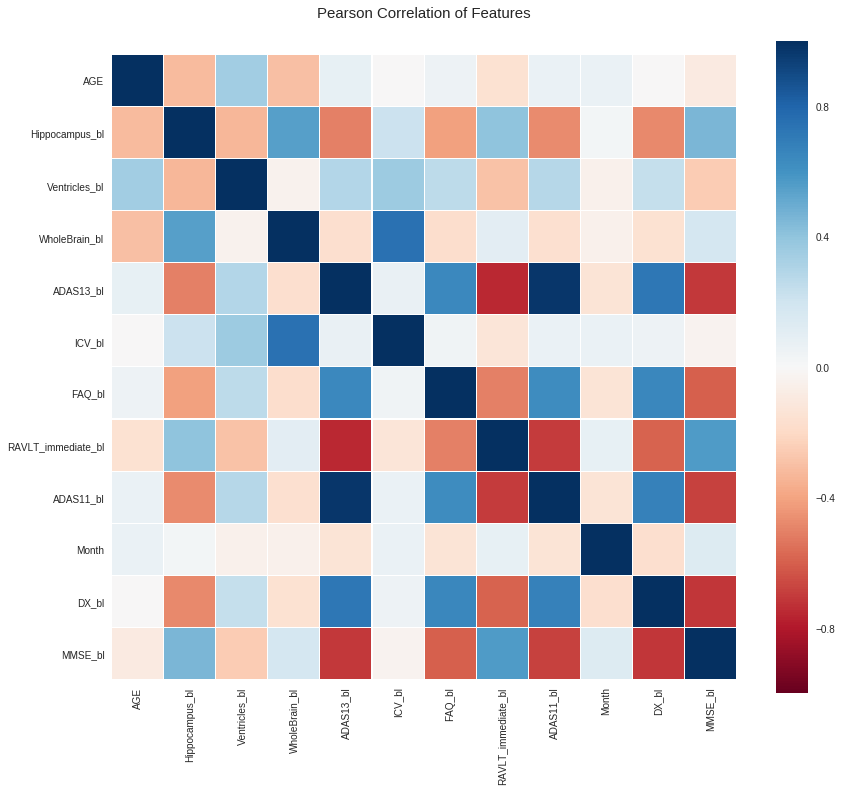

In [0]:
plot_df_data3 = Input_Data[['AGE','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl',
                            'ICV_bl','FAQ_bl','RAVLT_immediate_bl',
                            'ADAS11_bl','Month','DX_bl','MMSE_bl']]
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(plot_df_data3.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=False)

**Statistic for DX and DXCHANGE**

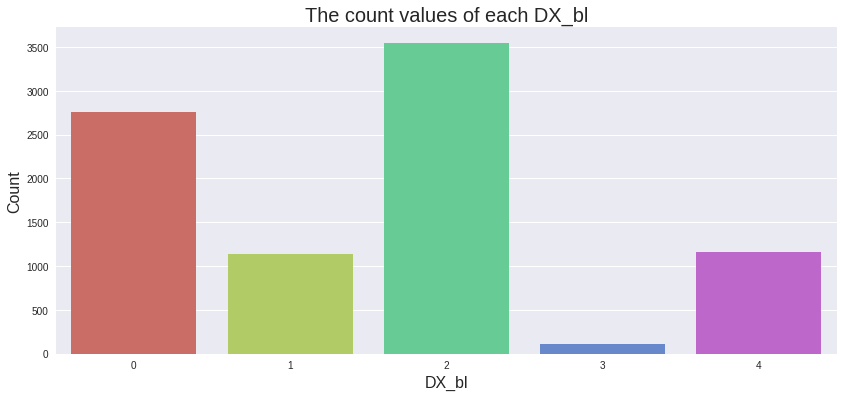

In [0]:
plt.figure(figsize=(14,6))


sns.countplot(Input_Data[Input_Data['DX_bl']\
                       .isin(Input_Data['DX_bl']\
                             .value_counts().index.values)]['DX_bl'], palette="hls") # It's a module to count the category's
plt.title("The count values of each DX_bl", fontsize=20) 
plt.xlabel("DX_bl", fontsize=16) 
plt.ylabel("Count", fontsize=16) 
plt.xticks() 

plt.show()

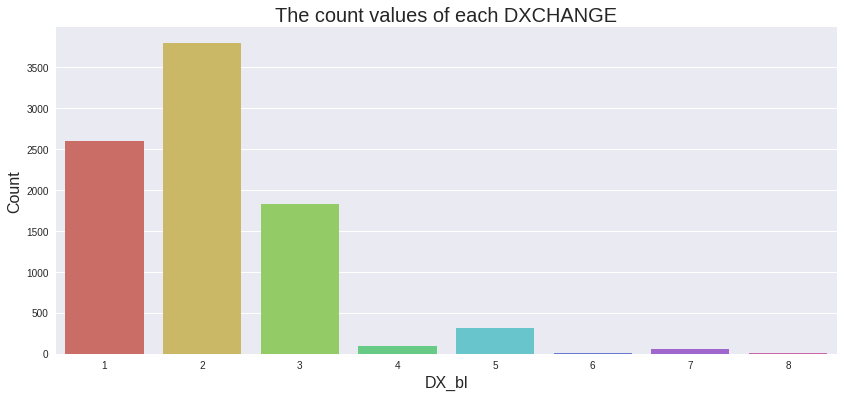

In [0]:
plt.figure(figsize=(14,6))


sns.countplot(Input_Data[Input_Data['DXCHANGE']\
                       .isin(Input_Data['DXCHANGE']\
                             .value_counts().index.values)]['DXCHANGE'], palette="hls") # It's a module to count the category's
plt.title("The count values of each DXCHANGE", fontsize=20) 
plt.xlabel("DX_bl", fontsize=16) 
plt.ylabel("Count", fontsize=16) 
plt.xticks() 

plt.show()

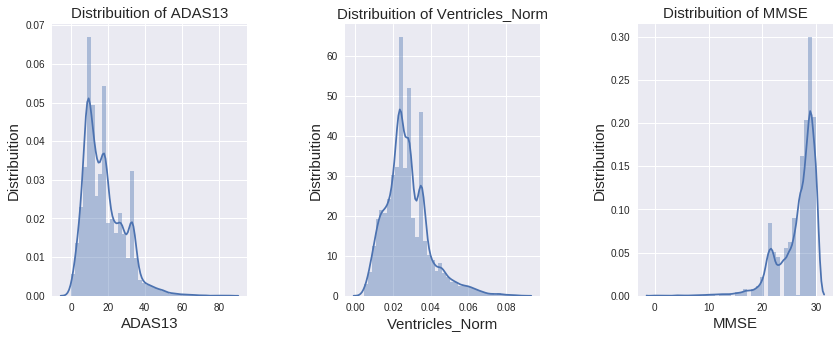

In [0]:
plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
ax = sns.distplot(Input_Data['ADAS13'], bins=40, kde=True)
ax.set_xlabel('ADAS13', fontsize=15) 
ax.set_ylabel('Distribuition', fontsize=15) 
ax.set_title("Distribuition of ADAS13", fontsize=15)

plt.subplot(1,3,2)
ax = sns.distplot(Input_Data['Ventricles_Norm'], bins=40, kde=True)
ax.set_xlabel('Ventricles_Norm', fontsize=15) 
ax.set_ylabel('Distribuition', fontsize=15) 
ax.set_title("Distribuition of Ventricles_Norm", fontsize=15)

plt.subplot(1,3,3)
ax = sns.distplot(Input_Data['MMSE'], bins=40, kde=True)
ax.set_xlabel('MMSE', fontsize=15) 
ax.set_ylabel('Distribuition', fontsize=15) 
ax.set_title("Distribuition of MMSE", fontsize=15)

plt.subplots_adjust(wspace = 0.5)
plt.show()

**Pairplots**

let us generate some pairplots to observe the distribution of data from one feature to the other.

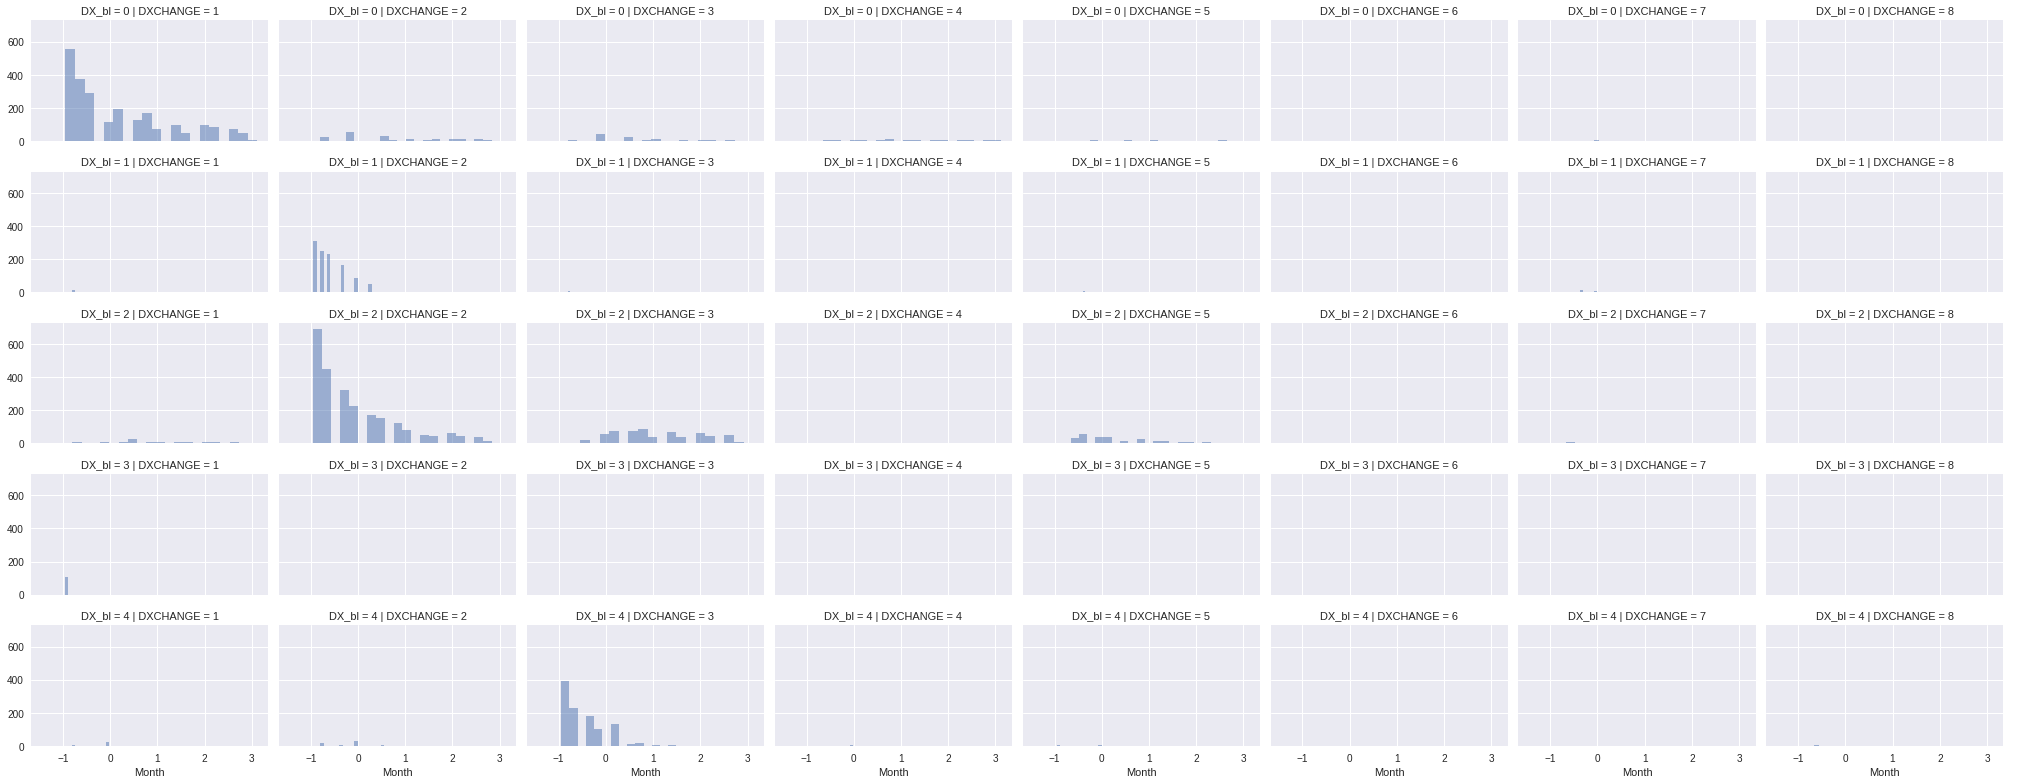

In [0]:
grid = sns.FacetGrid(Input_Data, col='DXCHANGE', row='DX_bl', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Month', alpha=.5, bins=20)
grid.add_legend()

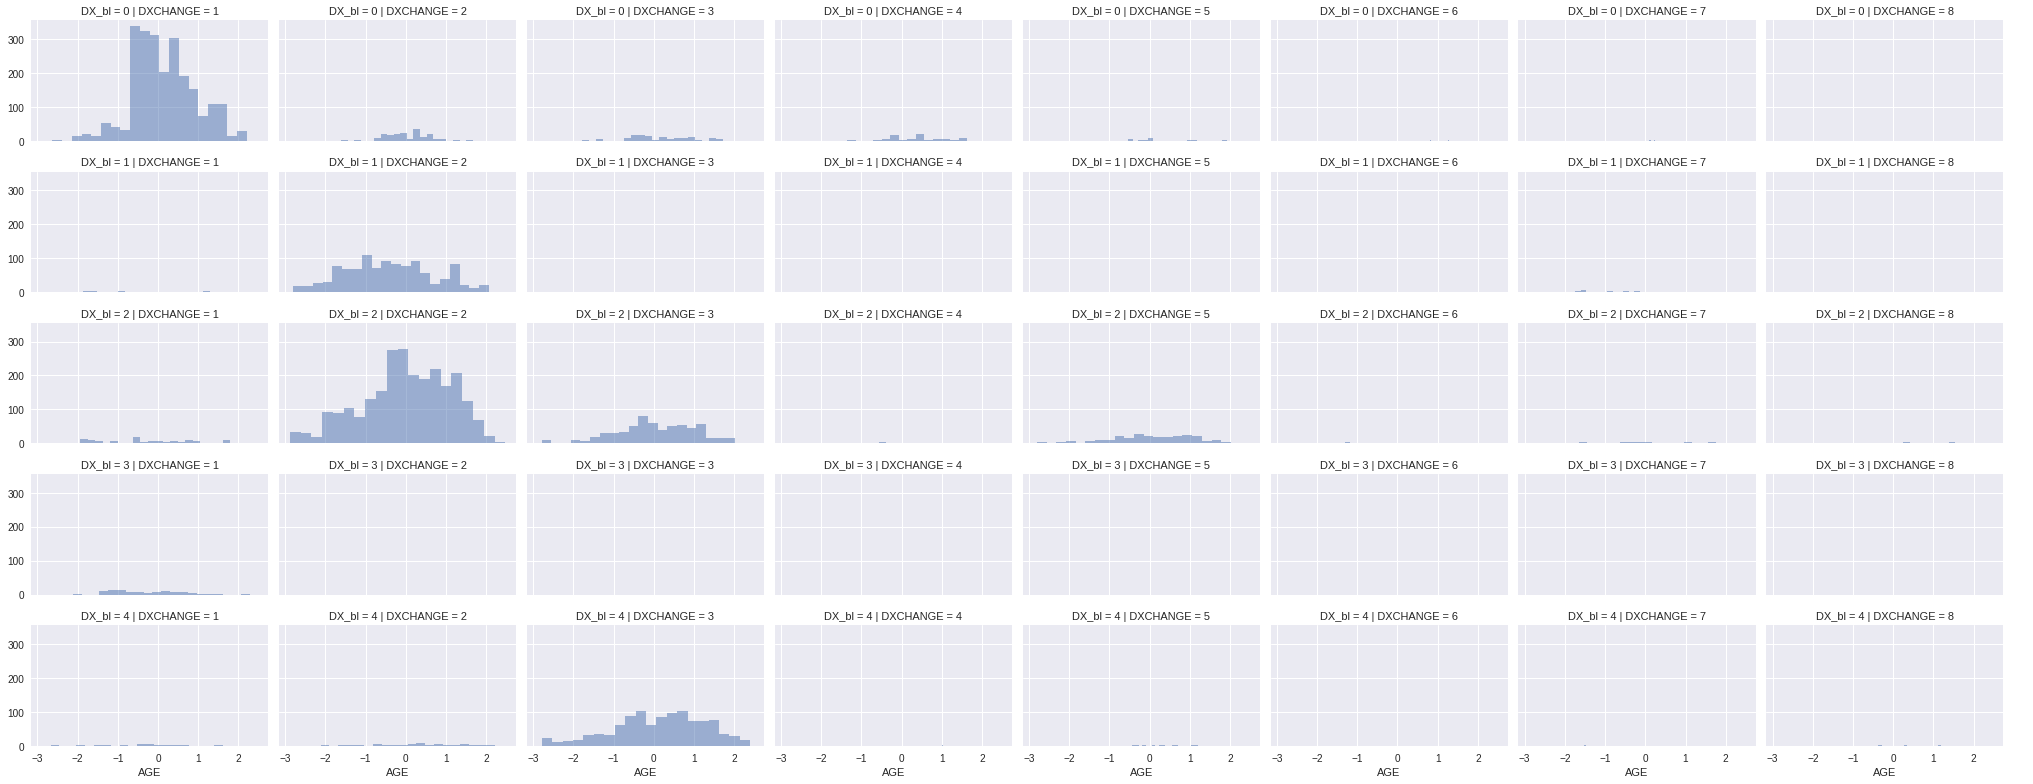

In [0]:
grid = sns.FacetGrid(Input_Data, col='DXCHANGE', row='DX_bl', size=2.2, aspect=1.6)
grid.map(plt.hist, 'AGE', alpha=.5, bins=20)
grid.add_legend()

## Skewness
It is the degree of distortion from the symmetrical bell curve or the normal distribution. It measures the lack of symmetry in data distribution.<br>
It differentiates extreme values in one versus the other tail. A symmetrical distribution will have a skewness of 0.

**Positive Skewness** means when the tail on the right side of the distribution is longer or fatter. The mean and median will be greater than the mode.  
** Negative Skewness** is when the tail of the left side of the distribution is longer or fatter than the tail on the right side. The mean and median will be less than the mode.

#### So, when is the skewness too much?
The rule of thumb seems to be:   
If the skewness is between -0.5 and 0.5, the data are fairly symmetrical.   
If the skewness is between -1 and -0.5(negatively skewed) or between 0.5 and 1(positively skewed), the data are moderately skewed.   
If the skewness is less than -1(negatively skewed) or greater than 1(positively skewed), the data are highly skewed.    

* **The DX_bl data are fairly symmetrical**

In [0]:
from scipy.stats import kurtosis, skew

print( 'Skewness of normal distribution for DX_bl (should be 0): {}'.format(
    skew((Input_Data['DX_bl']))))

Skewness of normal distribution for DX_bl (should be 0): 0.45559378579806664


* ** The DXCHANGE data are highly skewed**

In [0]:
print( 'Skewness of normal distribution for DXCHANGE (should be 0): {}'.format(
    skew((Input_Data['DXCHANGE']))))

Skewness of normal distribution for DXCHANGE (should be 0): 1.6406171823868512


# Train target

In [0]:
train_target = pd.read_csv('TADPOLE_TargetData_train.csv')

train_target.rename(index=str,columns={'Date':'EXAMDATE'},inplace=True)
# normalize the format of EXAMDATE
train_target['EXAMDATE'] = pd.to_datetime(train_target['EXAMDATE'])

train_target.head()

,EXAMDATE,PTID_Key,CN_Diag,MCI_Diag,AD_Diag,ADAS13,Ventricles_Norm,MMSE
0,2013-07-10,785,0.0,1.0,0.0,5.0,0.012737,28.0
1,2013-01-15,785,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-01-17,785,NaN,NaN,NaN,NaN,NaN,NaN
3,2014-07-29,785,1.0,0.0,0.0,7.0,NaN,30.0
4,2015-07-24,785,1.0,0.0,0.0,11.0,0.013934,25.0


In [0]:
# We can see if there is objects in train_target but not in df_data
train_target_id = list(set(train_target['PTID_Key'].values))
IDlist=[]
for ID in train_target_id:
    if ID not in Input_Data['PTID_Key'].values:
        IDlist.append(ID)
if len(IDlist)==0:
    print("All objects in the train target file are in input data file")
else:
    print("% objects in the train target file are not in input data file:" % (len(IDlist)),IDlist)

All objects in the train target file are in input data file


In [0]:
# find the objects baseline
## put DX_bl and baseline date into train target
train_target['DX_bl'] = 0
train_target['DX_DATE'] = 0
train_target['DX_DATE'] = pd.to_datetime(train_target['DX_DATE'])

for ID in train_target_id:
    baseline_DX = Input_Data[Input_Data['PTID_Key']==ID].DX_bl.values[0]
    baseline_DATE = Input_Data[Input_Data['PTID_Key']==ID].EXAMDATE_bl.values[0]
    idx = train_target[train_target['PTID_Key']==ID].index.values
    train_target.loc[idx,'DX_bl'] = baseline_DX
    train_target.loc[idx,'DX_DATE'] = baseline_DATE
    
train_target.head()

,EXAMDATE,PTID_Key,CN_Diag,MCI_Diag,AD_Diag,ADAS13,Ventricles_Norm,MMSE,DX_bl,DX_DATE
0,2013-07-10,785,0.0,1.0,0.0,5.0,0.012737,28.0,1,2011-07-13
1,2013-01-15,785,NaN,NaN,NaN,NaN,NaN,NaN,1,2011-07-13
2,2014-01-17,785,NaN,NaN,NaN,NaN,NaN,NaN,1,2011-07-13
3,2014-07-29,785,1.0,0.0,0.0,7.0,NaN,30.0,1,2011-07-13
4,2015-07-24,785,1.0,0.0,0.0,11.0,0.013934,25.0,1,2011-07-13


In [0]:
train_target['Month'] = np.ceil((train_target['EXAMDATE']-train_target['DX_DATE'])/np.timedelta64(1, 'M'))

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_target['Month'] = scaler.fit_transform(train_target['Month'].values.reshape(-1,1))

** Add selected baseline features**

In [0]:
Input_Data.columns.values

array(['PTID_Key', 'DX_bl', 'DXCHANGE', 'AGE', 'APOE4', 'CDRSB', 'ADAS11',
       'ADAS13', 'MMSE', 'RAVLT_immediate', 'FAQ', 'Ventricles_Norm',
       'Hippocampus', 'WholeBrain', 'Entorhinal', 'Fusiform', 'MidTemp',
       'ICV', 'EXAMDATE_bl', 'CDRSB_bl', 'ADAS11_bl', 'ADAS13_bl',
       'MMSE_bl', 'RAVLT_immediate_bl', 'FAQ_bl', 'Ventricles_bl',
       'Hippocampus_bl', 'WholeBrain_bl', 'Entorhinal_bl', 'Fusiform_bl',
       'MidTemp_bl', 'ICV_bl', 'Month'], dtype=object)

In [0]:
baseline_features = ['AGE','Hippocampus_bl','Ventricles_bl',
                 'WholeBrain_bl','ADAS13_bl','ICV_bl','FAQ_bl','RAVLT_immediate_bl',
                            'ADAS11_bl','MMSE_bl','CDRSB_bl']

for feature in baseline_features:
    train_target[feature] = 0
    for ID in train_target_id:
        baseline_value = Input_Data[Input_Data['PTID_Key']==ID][feature].values[0]        
        idx = train_target[train_target['PTID_Key']==ID].index.values
        train_target.loc[idx,feature] = baseline_value        

In [0]:
# Let's see how many null dada
print(train_target.isnull().sum())
print('*'*60)
print(train_target.info())

EXAMDATE                 0
PTID_Key                 0
CN_Diag                877
MCI_Diag               877
AD_Diag                877
ADAS13                 869
Ventricles_Norm       1638
MMSE                   848
DX_bl                    0
DX_DATE                  0
Month                    0
AGE                      0
Hippocampus_bl           0
Ventricles_bl            0
WholeBrain_bl            0
ADAS13_bl                0
ICV_bl                   0
FAQ_bl                   0
RAVLT_immediate_bl       0
ADAS11_bl                0
MMSE_bl                  0
CDRSB_bl                 0
dtype: int64
************************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 2506 entries, 0 to 2505
Data columns (total 22 columns):
EXAMDATE              2506 non-null datetime64[ns]
PTID_Key              2506 non-null int64
CN_Diag               1629 non-null float64
MCI_Diag              1629 non-null float64
AD_Diag               1629 non-null float64
ADAS1

In [0]:
# obejects just appear one time and the CN_Diag is missing in train target file
oneTime_id = []
for ID in train_target_id:
    if len(train_target[train_target['PTID_Key']==ID]) == 1:
        if train_target[train_target['PTID_Key']==ID]['CN_Diag'].values== 'nan':
            oneTime_id.append(ID)
if len(oneTime_id)==0:
    print('You can fill the missing data of CN_Diag, MCI_Diag and AD_Diag with the data of same object')
else:
    print('You should find another mothod to fillna')

You can fill the missing data of CN_Diag, MCI_Diag and AD_Diag with the data of same object


In [0]:
# sort the data by DX_bl and Month, then fill the missing data
train_target = train_target.sort_values(by=['PTID_Key','Month'])
train_target = train_target.reset_index(drop=True)

In [0]:
train_target.head()

,EXAMDATE,PTID_Key,CN_Diag,MCI_Diag,AD_Diag,ADAS13,Ventricles_Norm,MMSE,DX_bl,DX_DATE,Month,AGE,Hippocampus_bl,Ventricles_bl,WholeBrain_bl,ADAS13_bl,ICV_bl,FAQ_bl,RAVLT_immediate_bl,ADAS11_bl,MMSE_bl,CDRSB_bl
0,2013-06-07,6,1.0,0.0,0.0,NaN,NaN,30.0,0,2006-04-26,1.513004,-0.569676,1.007514,0.016364,0.689798,4.67,0.148749,-0.632635,1.961472,-1.082934,30.0,-0.881757
1,2013-10-16,6,NaN,NaN,NaN,NaN,NaN,NaN,0,2006-04-26,1.640769,-0.569676,1.007514,0.016364,0.689798,4.67,0.148749,-0.632635,1.961472,-1.082934,30.0,-0.881757
2,2014-05-29,6,1.0,0.0,0.0,3.0,NaN,30.0,0,2006-04-26,1.896299,-0.569676,1.007514,0.016364,0.689798,4.67,0.148749,-0.632635,1.961472,-1.082934,30.0,-0.881757
3,2016-05-05,6,1.0,0.0,0.0,1.0,NaN,29.0,0,2006-04-26,2.630948,-0.569676,1.007514,0.016364,0.689798,4.67,0.148749,-0.632635,1.961472,-1.082934,30.0,-0.881757
4,2013-03-28,8,NaN,NaN,NaN,NaN,NaN,NaN,0,2011-10-27,-0.659002,-0.424765,-0.808087,0.010878,-0.762274,8.00,-1.652026,-0.632635,1.372808,-0.857989,28.0,-0.881757


## train_data for ADAS13

In [0]:
features_adas13 = ['AGE','Hippocampus_bl','Ventricles_bl',
                 'WholeBrain_bl','ADAS13_bl','ICV_bl','FAQ_bl','RAVLT_immediate_bl',
                            'ADAS11_bl','MMSE_bl','CDRSB_bl','Month','DX_bl','ADAS13']
# data in train_target
train_adas13_input1 = train_target[features_adas13].dropna(axis=0)

# data in Input_Data
train_adas13_input2 = Input_Data[features_adas13]

# append those two sets of data
train_adas13 = train_adas13_input1.append(train_adas13_input2)

X_train_adas13 = train_adas13[['AGE','Hippocampus_bl','Ventricles_bl',
                 'WholeBrain_bl','ADAS13_bl','ICV_bl','FAQ_bl','RAVLT_immediate_bl',
                            'ADAS11_bl','MMSE_bl','CDRSB_bl','Month','DX_bl']]
y_train_adas13 = train_adas13['ADAS13']

* **correlation**
 * right corner shows high correlation

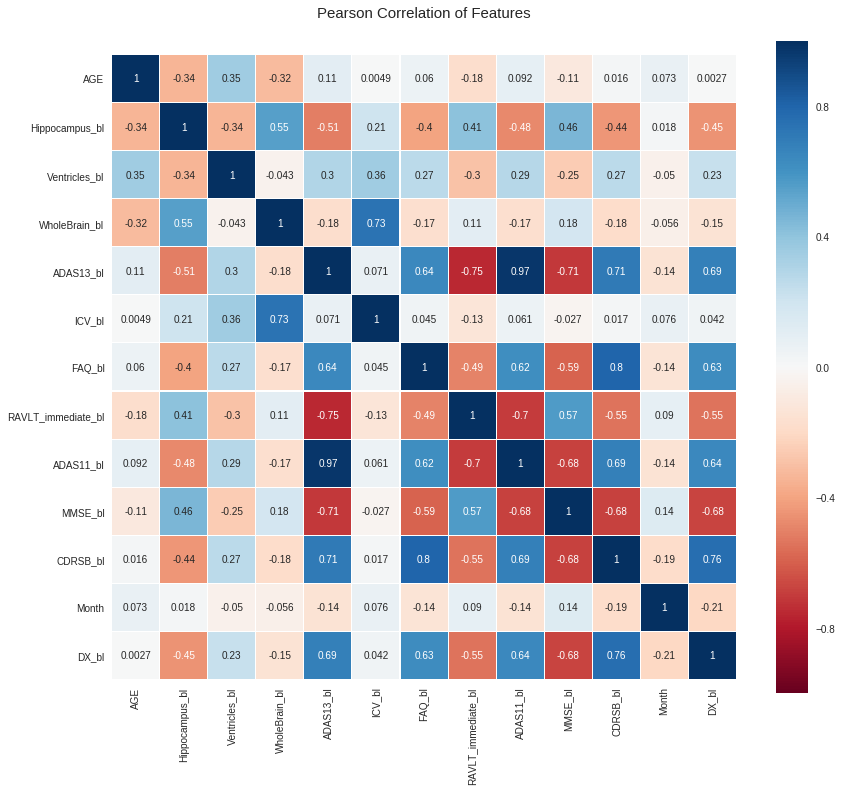

In [0]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(X_train_adas13.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

* **let see the distribuition of ADAS13**

ADAS13 Min Value:  0.0
ADAS13 Mean Value:  17.669753138473876
ADAS13 Median Value:  15.0
ADAS13 Max Value:  85.0


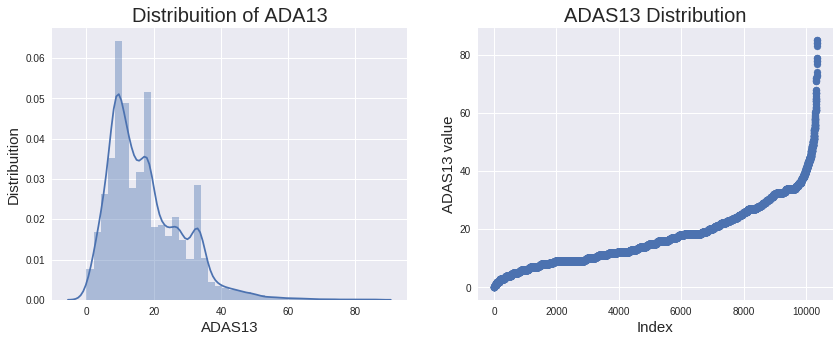

In [0]:
print("ADAS13 Min Value: ", 
      y_train_adas13.min()) 
print("ADAS13 Mean Value: ", 
       y_train_adas13.mean())
print("ADAS13 Median Value: ", 
       y_train_adas13.median()) 
print("ADAS13 Max Value: ", 
       y_train_adas13.max()) 

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.distplot(y_train_adas13, bins=40, kde=True)
ax.set_xlabel('ADAS13', fontsize=15) 
ax.set_ylabel('Distribuition', fontsize=15) 
ax.set_title("Distribuition of ADA13", fontsize=20) 

plt.subplot(1,2,2)
plt.scatter(range( y_train_adas13.shape[0]), np.sort( y_train_adas13.values))
plt.xlabel('Index', fontsize=15)
plt.ylabel('ADAS13 value', fontsize=15)
plt.title("ADAS13 Distribution", fontsize=20)

plt.show()

In [0]:
print( 'Skewness of normal distribution (should be 0): {}'.format(
    skew(y_train_adas13)))

Skewness of normal distribution (should be 0): 1.19178300887759


In [0]:
train_adas13_2 = train_adas13[train_adas13['ADAS13']<=33]
X_train_adas13_2 = train_adas13_2[['AGE','Hippocampus_bl','Ventricles_bl',
                 'WholeBrain_bl','ADAS13_bl','ICV_bl','FAQ_bl','RAVLT_immediate_bl',
                            'ADAS11_bl','MMSE_bl','CDRSB_bl','Month','DX_bl']]
y_train_adas13_2 = train_adas13_2['ADAS13']

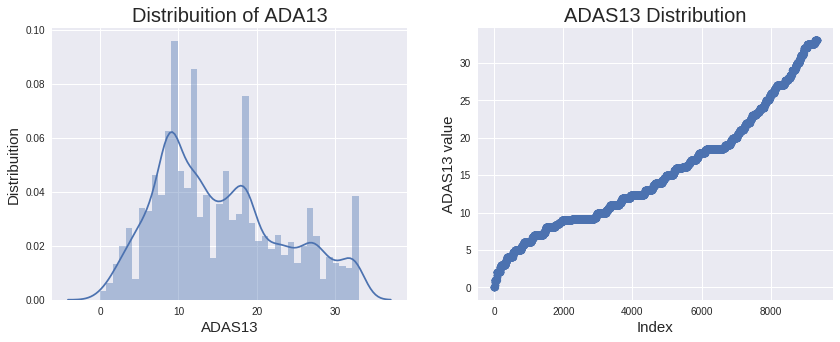

In [0]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.distplot(y_train_adas13_2, bins=40, kde=True)
ax.set_xlabel('ADAS13', fontsize=15) 
ax.set_ylabel('Distribuition', fontsize=15) 
ax.set_title("Distribuition of ADA13", fontsize=20) 

plt.subplot(1,2,2)
plt.scatter(range( y_train_adas13_2.shape[0]), np.sort( y_train_adas13_2.values))
plt.xlabel('Index', fontsize=15)
plt.ylabel('ADAS13 value', fontsize=15)
plt.title("ADAS13 Distribution", fontsize=20)

plt.show()

In [0]:
print( 'Skewness of normal distribution (should be 0): {}'.format(
    skew(y_train_adas13_2)))

Skewness of normal distribution (should be 0): 0.4978216004537847


* **Let's see the difference distribution between DX_bl**

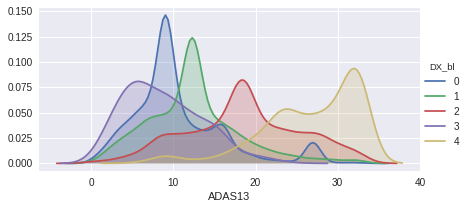

In [0]:
(sns.FacetGrid(train_adas13_2,
               hue='DX_bl',  aspect=2)
  .map(sns.kdeplot, 'ADAS13', shade=True)
 .add_legend()
)
plt.show()

## train_data for Ventricels_Norm

In [0]:
features_ventricles = ['AGE','Hippocampus_bl','Ventricles_bl',
                 'WholeBrain_bl','ADAS13_bl','ICV_bl','FAQ_bl','RAVLT_immediate_bl',
                            'ADAS11_bl','MMSE_bl','CDRSB_bl','Month','DX_bl','Ventricles_Norm']
# data in train_target
train_ventricles_input1 = train_target[features_ventricles].dropna(axis=0)

# data in Input_Data
train_ventricles_input2 = Input_Data[features_ventricles]

# append those two sets of data
train_ventricles = train_ventricles_input1.append(train_ventricles_input2)

# X_train_ventricles = train_ventricles[['DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
#                   'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl']]
X_train_ventricles = train_ventricles[['AGE','Hippocampus_bl','Ventricles_bl',
                 'WholeBrain_bl','ADAS13_bl','ICV_bl','FAQ_bl','RAVLT_immediate_bl',
                            'ADAS11_bl','MMSE_bl','CDRSB_bl','Month','DX_bl']]
y_train_ventricles = train_ventricles['Ventricles_Norm']

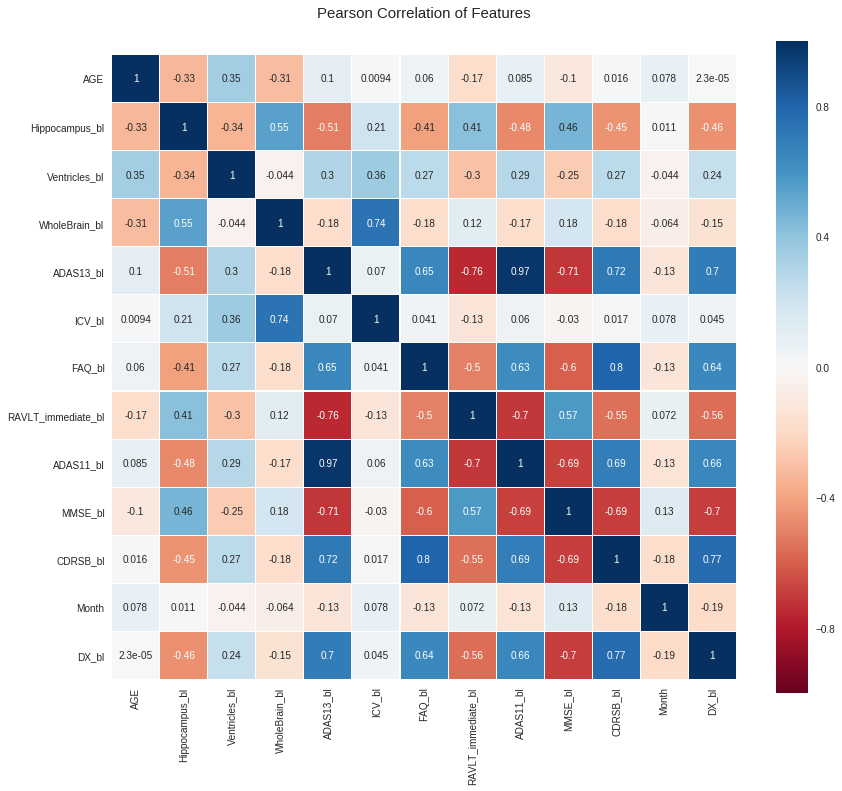

In [0]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(X_train_ventricles.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

* **let see the distribuition of Ventricles_Norm**

 Ventricles_Norm Min Value:  0.004502658931592941
 Ventricles_Norm Mean Value:  0.027341854095823494
 Ventricles_Norm Median Value:  0.02550315528427536
 Ventricles_Norm Max Value:  0.08795257121052277


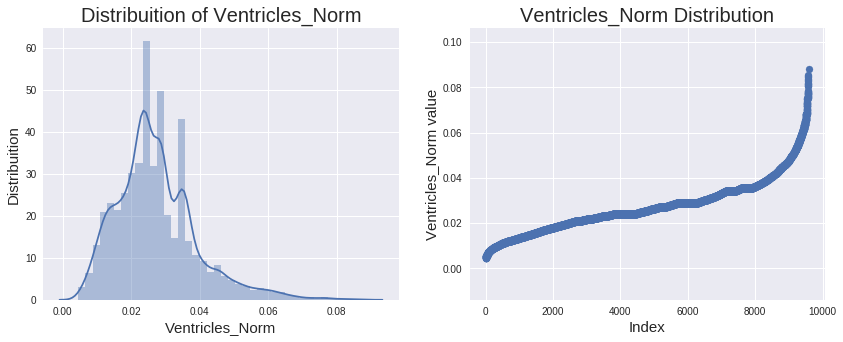

In [0]:
print(" Ventricles_Norm Min Value: ", 
      y_train_ventricles.min()) 
print(" Ventricles_Norm Mean Value: ", 
       y_train_ventricles.mean())
print(" Ventricles_Norm Median Value: ", 
       y_train_ventricles.median()) 
print(" Ventricles_Norm Max Value: ", 
       y_train_ventricles.max()) 

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.distplot(y_train_ventricles, bins=40, kde=True)
ax.set_xlabel('Ventricles_Norm', fontsize=15) 
ax.set_ylabel('Distribuition', fontsize=15) 
ax.set_title("Distribuition of Ventricles_Norm", fontsize=20) 

plt.subplot(1,2,2)
plt.scatter(range( y_train_ventricles.shape[0]), np.sort( y_train_ventricles.values))
plt.xlabel('Index', fontsize=15)
plt.ylabel('Ventricles_Norm value', fontsize=15)
plt.title("Ventricles_Norm Distribution", fontsize=20)

plt.show()

In [0]:
print( 'Skewness of normal distribution (should be 0): {}'.format(
    skew(y_train_ventricles)))

Skewness of normal distribution (should be 0): 1.0389335934408752


In [0]:
train_ventricles_2 = train_ventricles[train_ventricles['Ventricles_Norm']<=0.055]
X_train_ventricles_2 = train_ventricles_2[['AGE','Hippocampus_bl','Ventricles_bl',
                 'WholeBrain_bl','ADAS13_bl','ICV_bl','FAQ_bl','RAVLT_immediate_bl',
                            'ADAS11_bl','MMSE_bl','CDRSB_bl','Month','DX_bl']]
y_train_ventricles_2 = train_ventricles_2['Ventricles_Norm']

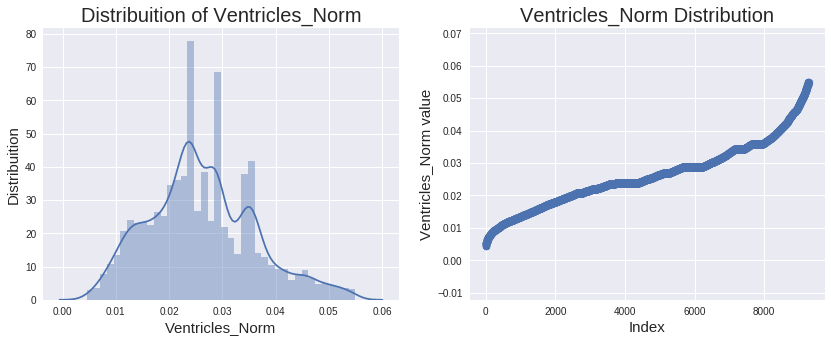

In [0]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.distplot(y_train_ventricles_2, bins=40, kde=True)
ax.set_xlabel('Ventricles_Norm', fontsize=15) 
ax.set_ylabel('Distribuition', fontsize=15) 
ax.set_title("Distribuition of Ventricles_Norm", fontsize=20) 

plt.subplot(1,2,2)
plt.scatter(range( y_train_ventricles_2.shape[0]), np.sort( y_train_ventricles_2.values))
plt.xlabel('Index', fontsize=15)
plt.ylabel('Ventricles_Norm value', fontsize=15)
plt.title("Ventricles_Norm Distribution", fontsize=20)

plt.show()

In [0]:
print( 'Skewness of normal distribution (should be 0): {}'.format(
    skew(y_train_ventricles_2)))

Skewness of normal distribution (should be 0): 0.39636385091446064


* **Let's see the difference distribution between DX_bl**

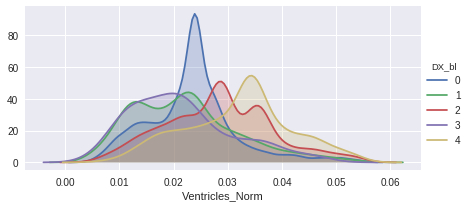

In [0]:
(sns.FacetGrid(train_ventricles_2,
               hue='DX_bl',  aspect=2)
  .map(sns.kdeplot, 'Ventricles_Norm', shade=True)
 .add_legend()
)
plt.show()

## train_data for MMSE

In [0]:
features_mmse = ['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl','MMSE']
# data in train_target
train_mmse_input1 = train_target[features_mmse].dropna(axis=0)

# data in Input_Data
train_mmse_input2 = Input_Data[features_mmse]

# append those two sets of data
train_mmse = train_mmse_input1.append(train_mmse_input2)

X_train_mmse = train_mmse[['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl']]
y_train_mmse = train_mmse['MMSE']

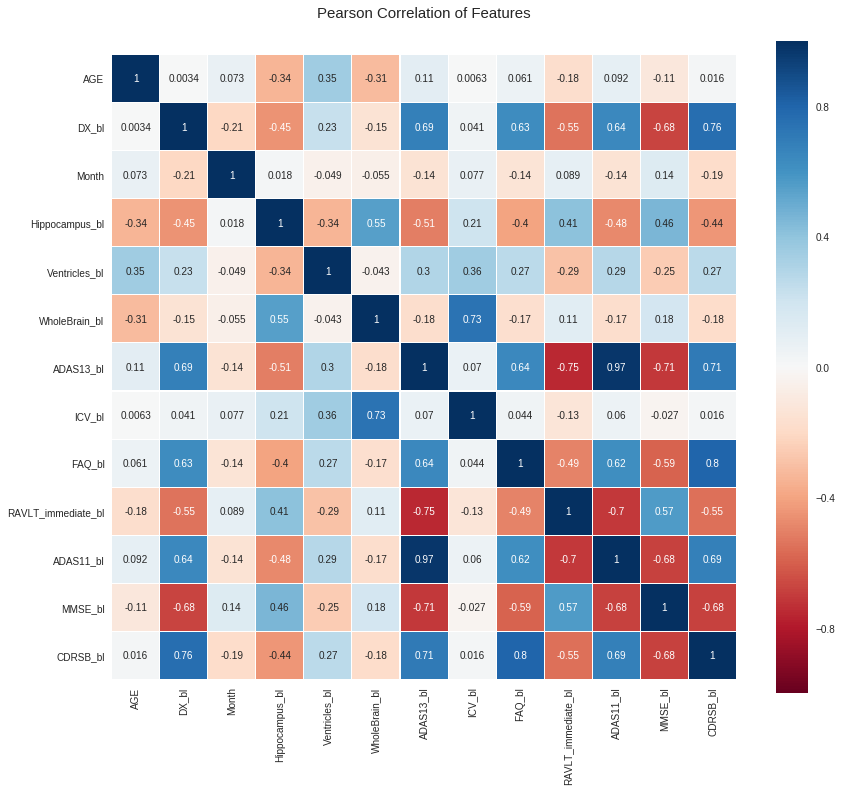

In [0]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(X_train_mmse.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

 MMSE Min Value:  0.0
 MMSE Mean Value:  26.57685823711871
 MMSE Median Value:  0.02550315528427536
 MMSE Max Value:  30.0


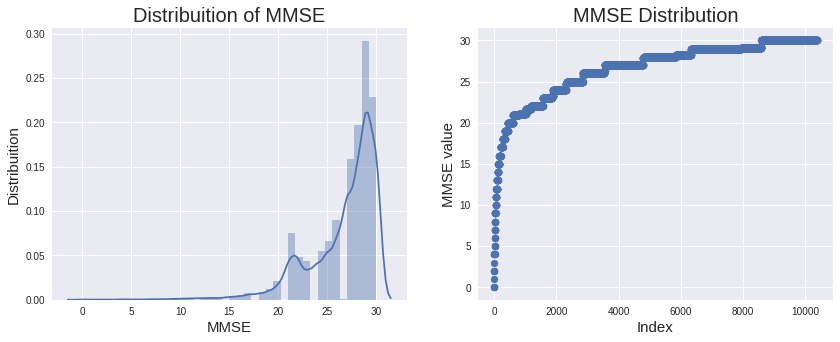

In [0]:
print(" MMSE Min Value: ", 
      y_train_mmse.min()) 
print(" MMSE Mean Value: ", 
       y_train_mmse.mean())
print(" MMSE Median Value: ", 
       y_train_ventricles.median()) 
print(" MMSE Max Value: ", 
       y_train_mmse.max()) 

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.distplot(y_train_mmse, bins=40, kde=True)
ax.set_xlabel('MMSE', fontsize=15) 
ax.set_ylabel('Distribuition', fontsize=15) 
ax.set_title("Distribuition of MMSE", fontsize=20) 

plt.subplot(1,2,2)
plt.scatter(range( y_train_mmse.shape[0]), np.sort( y_train_mmse.values))
plt.xlabel('Index', fontsize=15)
plt.ylabel('MMSE value', fontsize=15)
plt.title("MMSE Distribution", fontsize=20)

plt.show()

In [0]:
print( 'Skewness of normal distribution (should be 0): {}'.format(
    skew(y_train_mmse)))

Skewness of normal distribution (should be 0): -1.9745859564881523


In [0]:
train_mmse_2 = train_mmse[train_mmse['MMSE']>=26]
X_train_mmse_2 = train_mmse_2[['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl']]
y_train_mmse_2 = train_mmse_2['MMSE']

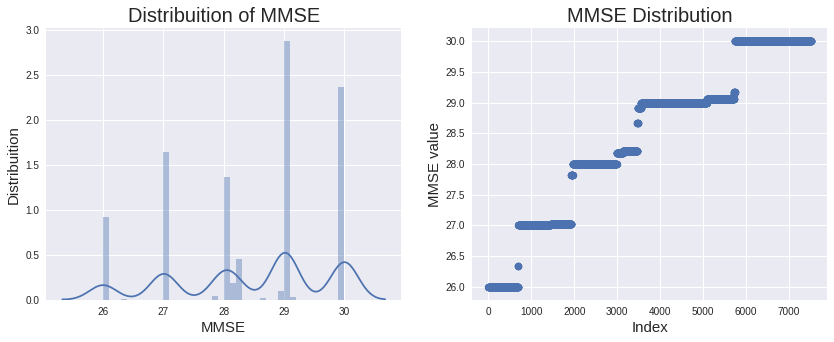

In [0]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.distplot(y_train_mmse_2, bins=40, kde=True)
ax.set_xlabel('MMSE', fontsize=15) 
ax.set_ylabel('Distribuition', fontsize=15) 
ax.set_title("Distribuition of MMSE", fontsize=20) 

plt.subplot(1,2,2)
plt.scatter(range( y_train_mmse_2.shape[0]), np.sort( y_train_mmse_2.values))
plt.xlabel('Index', fontsize=15)
plt.ylabel('MMSE value', fontsize=15)
plt.title("MMSE Distribution", fontsize=20)

plt.show()

In [0]:
print( 'Skewness of normal distribution (should be 0): {}'.format(
    skew(y_train_mmse_2)))

Skewness of normal distribution (should be 0): -0.44663544190527793


* **Let's see the difference distribution between DX_bl**

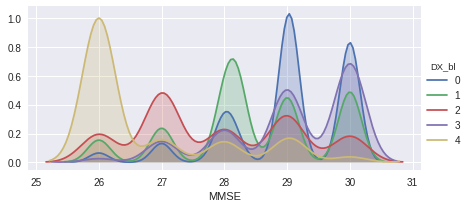

In [0]:
(sns.FacetGrid(train_mmse_2,
               hue='DX_bl',  aspect=2)
  .map(sns.kdeplot, 'MMSE', shade=True)
 .add_legend()
)
plt.show()

## train_data for Diag
* No Diag in the Input_Data

In [0]:
# features_diag = ['AGE','DX_bl','Month','MMSE','Ventricles_Norm','ADAS13','CN_Diag','MCI_Diag','AD_Diag']
features_diag = ['AGE','DX_bl','Month','MMSE','ADAS13','CN_Diag','MCI_Diag','AD_Diag']
# data in train_target
train_diag = train_target[features_diag].dropna(axis=0)

# X_train_diag = train_diag[['AGE','DX_bl','Month','MMSE','Ventricles_Norm','ADAS13']]
X_train_diag = train_diag[['AGE','DX_bl','Month','MMSE','ADAS13']]
y_train_diag = train_diag[['CN_Diag','MCI_Diag','AD_Diag']]

y_train_diag['CN_Diag'] = y_train_diag['CN_Diag'].astype('int')
y_train_diag['MCI_Diag'] = y_train_diag['MCI_Diag'].astype('int')
y_train_diag['AD_Diag'] = y_train_diag['AD_Diag'].astype('int')

y_train_diag['Diag'] = np.argmax(y_train_diag[['CN_Diag','MCI_Diag','AD_Diag']].values,axis=1)
y_train_diag1 = y_train_diag['Diag']
y_train_diag2 = y_train_diag[['CN_Diag','MCI_Diag','AD_Diag']]

In [0]:
train_diag_2 = train_target[['AGE','DX_bl','Month','MMSE','Ventricles_Norm','ADAS13','CN_Diag','MCI_Diag','AD_Diag']].dropna(axis=0)
X_train_diag_2 = train_diag_2[['AGE','DX_bl','Month','MMSE','Ventricles_Norm','ADAS13']]
y_train_diag_2 = train_diag_2[['CN_Diag','MCI_Diag','AD_Diag']]
y_train_diag_2['CN_Diag'] = y_train_diag_2['CN_Diag'].astype('int')
y_train_diag_2['MCI_Diag'] = y_train_diag_2['MCI_Diag'].astype('int')
y_train_diag_2['AD_Diag'] = y_train_diag_2['AD_Diag'].astype('int')

y_train_diag_2['Diag'] = np.argmax(y_train_diag_2[['CN_Diag','MCI_Diag','AD_Diag']].values,axis=1)

In [0]:
plot_df = train_diag
plot_df['Diag']= y_train_diag1
plot_df = plot_df.drop(columns=['CN_Diag','MCI_Diag','AD_Diag'],axis=1)

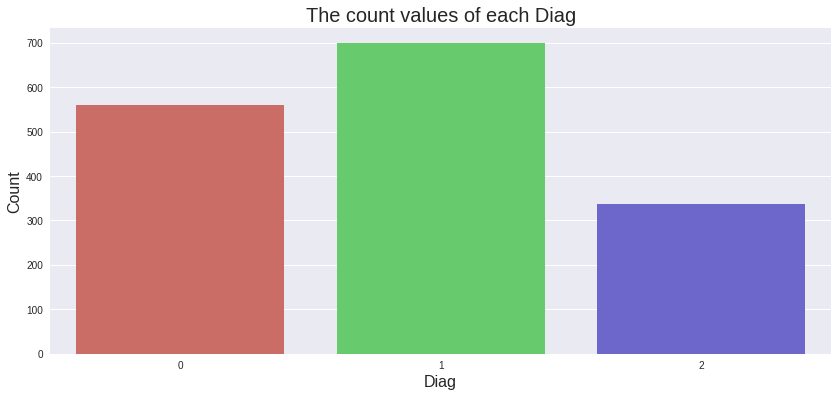

In [0]:
plt.figure(figsize=(14,6))


sns.countplot(plot_df[plot_df['Diag']\
                       .isin(plot_df['Diag']\
                             .value_counts().index.values)]['Diag'], palette="hls") # It's a module to count the category's
plt.title("The count values of each Diag", fontsize=20) 
plt.xlabel("Diag", fontsize=16) 
plt.ylabel("Count", fontsize=16) 
plt.xticks() 

plt.show()

* **The Diag data are fairly symmtrical.**

In [0]:
print( 'Skewness of normal distribution (should be 0): {}'.format(
    skew(plot_df['Diag'])))

Skewness of normal distribution (should be 0): 0.22527663534656647


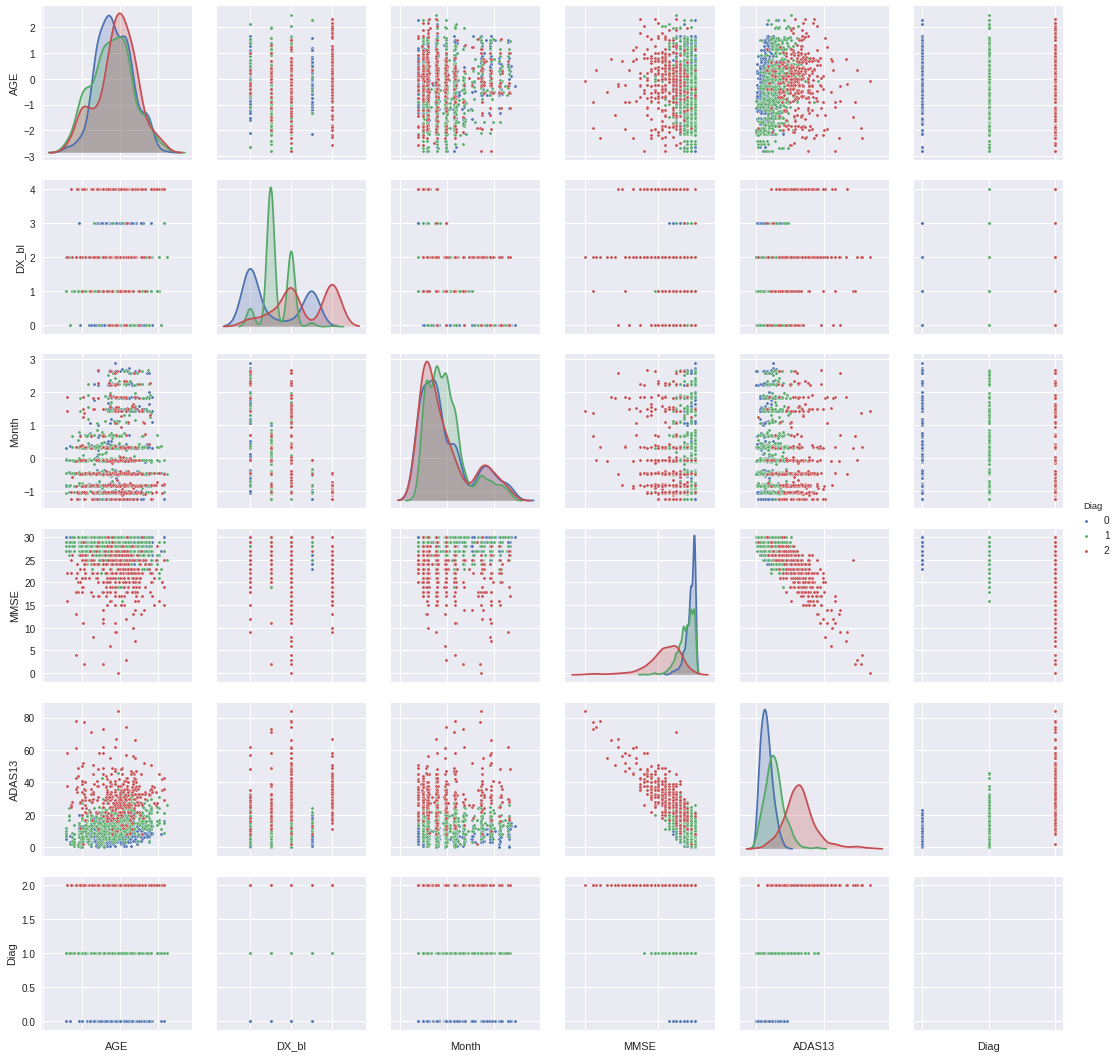

In [0]:
g = sns.pairplot(plot_df, hue='Diag',diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

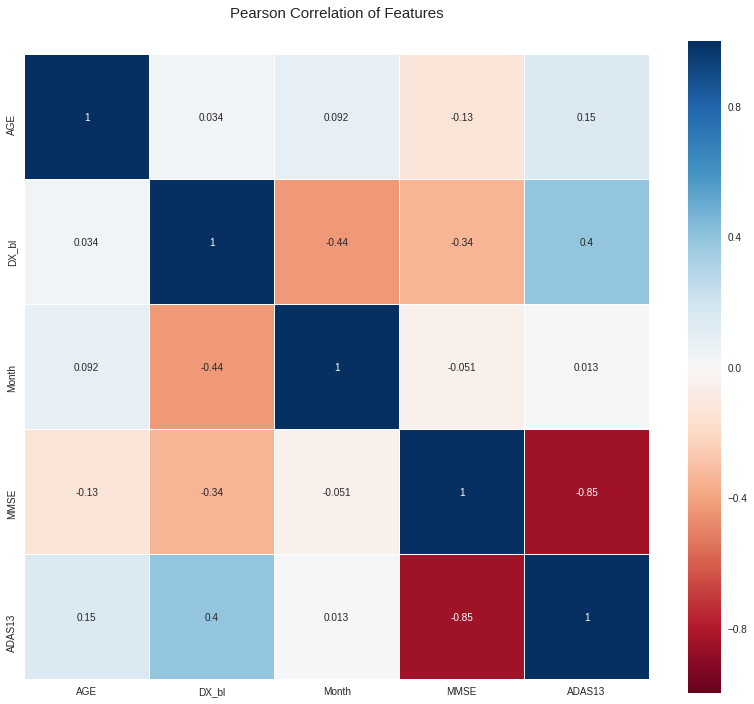

In [0]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(X_train_diag.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

# Validation target

In [0]:
validation_target = pd.read_csv('TADPOLE_TargetData_validation.csv')

validation_target.rename(index=str,columns={'Date':'EXAMDATE'},inplace=True)
# normalize the format of EXAMDATE
validation_target['EXAMDATE'] = pd.to_datetime(validation_target['EXAMDATE'])

validation_target.head()

,EXAMDATE,PTID_Key,CN_Diag,MCI_Diag,AD_Diag,ADAS13,Ventricles_Norm,MMSE
0,2014-01-02,1603,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-15,1603,NaN,NaN,NaN,NaN,NaN,NaN
2,2014-10-29,1603,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-08-11,1603,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-07-18,1603,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
# We can see if there is objects in train_target but not in df_data
validation_target_id = list(set(validation_target['PTID_Key'].values))
IDlist=[]
for ID in validation_target_id:
    if ID not in Input_Data['PTID_Key'].values:
        IDlist.append(ID)
if len(IDlist)==0:
    print("All objects in the validation target file are in input data file")
else:
    print("% objects in the validation target file are not in input data file:" % (len(IDlist)),IDlist)

All objects in the validation target file are in input data file


In [0]:
# find the objects baseline
## put DX_bl and baseline date into validation target
validation_target['DX_bl'] = 0
validation_target['DX_DATE'] = 0
validation_target['DX_DATE'] = pd.to_datetime(validation_target['DX_DATE'])

for ID in validation_target_id:
    baseline_DX = Input_Data[Input_Data['PTID_Key']==ID].DX_bl.values[0]
    baseline_DATE = Input_Data[Input_Data['PTID_Key']==ID].EXAMDATE_bl.values[0]
    idx = validation_target[validation_target['PTID_Key']==ID].index.values
    validation_target.loc[idx,'DX_bl'] = baseline_DX
    validation_target.loc[idx,'DX_DATE'] = baseline_DATE
    
validation_target.head()

,EXAMDATE,PTID_Key,CN_Diag,MCI_Diag,AD_Diag,ADAS13,Ventricles_Norm,MMSE,DX_bl,DX_DATE
0,2014-01-02,1603,NaN,NaN,NaN,NaN,NaN,NaN,4,2012-07-05
1,2015-01-15,1603,NaN,NaN,NaN,NaN,NaN,NaN,4,2012-07-05
2,2014-10-29,1603,NaN,NaN,NaN,NaN,NaN,NaN,4,2012-07-05
3,2015-08-11,1603,NaN,NaN,NaN,NaN,NaN,NaN,4,2012-07-05
4,2016-07-18,1603,NaN,NaN,NaN,NaN,NaN,NaN,4,2012-07-05


In [0]:
validation_target['Month'] = np.ceil((validation_target['EXAMDATE']-validation_target['DX_DATE'])/np.timedelta64(1, 'M'))

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
validation_target['Month'] = scaler.fit_transform(validation_target['Month'].values.reshape(-1,1))

In [0]:
baseline_features = ['AGE','Hippocampus_bl','Ventricles_bl',
                 'WholeBrain_bl','ADAS13_bl','ICV_bl','FAQ_bl','RAVLT_immediate_bl',
                            'ADAS11_bl','MMSE_bl','CDRSB_bl']

for feature in baseline_features:
    validation_target[feature] = 0
    for ID in validation_target_id:
        baseline_value = Input_Data[Input_Data['PTID_Key']==ID][feature].values[0]        
        idx = validation_target[validation_target['PTID_Key']==ID].index.values
        validation_target.loc[idx,feature] = baseline_value    

In [0]:
# sort the data by DX_bl and Month, then fill the missing data
validation_target = validation_target.sort_values(by=['PTID_Key','Month'])
validation_target = validation_target.reset_index(drop=True)

In [0]:
features_adas13 = ['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl','ADAS13']
# data in train_target
validation_adas13 = validation_target[features_adas13].dropna(axis=0)

X_validation_adas13 = validation_adas13[['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl']]
y_validation_adas13 = validation_adas13['ADAS13']

In [0]:
features_ventricles = ['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl','Ventricles_Norm']
# data in train_target
validation_ventricles = validation_target[features_ventricles].dropna(axis=0)

X_validation_ventricles = validation_ventricles[['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl']]
y_validation_ventricles = validation_ventricles['Ventricles_Norm']

In [0]:
features_mmse = ['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl','MMSE']
# data in train_target
validation_mmse = validation_target[features_mmse].dropna(axis=0)

X_validation_mmse = validation_mmse[['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl']]
y_validation_mmse = validation_mmse['MMSE']

In [0]:
features_diag = ['AGE','DX_bl','Month','MMSE','ADAS13','CN_Diag','MCI_Diag','AD_Diag']
# data in train_target
validation_diag = validation_target[features_diag].dropna(axis=0)

X_validation_diag = validation_diag[['AGE','DX_bl','Month','MMSE','ADAS13']]
y_validation_diag = validation_diag[['CN_Diag','MCI_Diag','AD_Diag']]

y_validation_diag['CN_Diag'] = y_validation_diag['CN_Diag'].astype('int')
y_validation_diag['MCI_Diag'] = y_validation_diag['MCI_Diag'].astype('int')
y_validation_diag['AD_Diag'] = y_validation_diag['AD_Diag'].astype('int')

y_validation_diag['Diag'] = np.argmax(y_validation_diag[['CN_Diag','MCI_Diag','AD_Diag']].values,axis=1)

y_validation_diag1 = y_validation_diag['Diag']
y_validation_diag2 = y_validation_diag[['CN_Diag','MCI_Diag','AD_Diag']]

In [0]:
validation_diag_2 = validation_target[['AGE','DX_bl','Month','MMSE','Ventricles_Norm','ADAS13','CN_Diag','MCI_Diag','AD_Diag']].dropna(axis=0)
X_validation_diag_2 = validation_diag_2[['AGE','DX_bl','Month','MMSE','Ventricles_Norm','ADAS13']]
y_validation_diag_2 = validation_diag_2[['CN_Diag','MCI_Diag','AD_Diag']]
y_validation_diag_2['CN_Diag'] = y_validation_diag_2['CN_Diag'].astype('int')
y_validation_diag_2['MCI_Diag'] = y_validation_diag_2['MCI_Diag'].astype('int')
y_validation_diag_2['AD_Diag'] = y_validation_diag_2['AD_Diag'].astype('int')

y_validation_diag_2['Diag'] = np.argmax(y_validation_diag_2[['CN_Diag','MCI_Diag','AD_Diag']].values,axis=1)

# Test target

In [0]:
test_target = pd.read_csv('TADPOLE_PredictTargetData_test.csv')

test_target.rename(index=str,columns={'Date':'EXAMDATE'},inplace=True)
# normalize the format of EXAMDATE
test_target['EXAMDATE'] = pd.to_datetime(test_target['EXAMDATE'])

In [0]:
# We can see if there is objects in train_target but not in df_data
test_target_id = list(set(test_target['PTID_Key'].values))
IDlist=[]
for ID in test_target_id:
    if ID not in Input_Data['PTID_Key'].values:
        IDlist.append(ID)
if len(IDlist)==0:
    print("All objects in the test target file are in input data file")
else:
    print("% objects in the test target file are not in input data file:" % (len(IDlist)),IDlist)

All objects in the test target file are in input data file


In [0]:
# find the objects baseline
## put DX_bl and baseline date into validation target
test_target['DX_bl'] = 0
test_target['DX_DATE'] = 0
test_target['DX_DATE'] = pd.to_datetime(test_target['DX_DATE'])

for ID in test_target_id:
    baseline_DX = Input_Data[Input_Data['PTID_Key']==ID].DX_bl.values[0]
    baseline_DATE = Input_Data[Input_Data['PTID_Key']==ID].EXAMDATE_bl.values[0]
    idx = test_target[test_target['PTID_Key']==ID].index.values
    test_target.loc[idx,'DX_bl'] = baseline_DX
    test_target.loc[idx,'DX_DATE'] = baseline_DATE
    
test_target.head()

,EXAMDATE,PTID_Key,CN_Diag,MCI_Diag,AD_Diag,ADAS13,Ventricles_Norm,MMSE,DX_bl,DX_DATE
0,2013-01-25,583,NaN,NaN,NaN,NaN,NaN,NaN,4,2011-06-14
1,2013-06-25,583,NaN,NaN,NaN,NaN,NaN,NaN,4,2011-06-14
2,2014-03-10,583,NaN,NaN,NaN,NaN,NaN,NaN,4,2011-06-14
3,2013-12-04,809,NaN,NaN,NaN,NaN,NaN,NaN,1,2011-11-04
4,2013-04-25,809,NaN,NaN,NaN,NaN,NaN,NaN,1,2011-11-04


In [0]:
test_target['Month'] = np.ceil((test_target['EXAMDATE']-test_target['DX_DATE'])/np.timedelta64(1, 'M'))

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
test_target['Month'] = scaler.fit_transform(test_target['Month'].values.reshape(-1,1))

In [0]:
baseline_features = ['AGE','Hippocampus_bl','Ventricles_bl',
                 'WholeBrain_bl','ADAS13_bl','ICV_bl','FAQ_bl','RAVLT_immediate_bl',
                            'ADAS11_bl','MMSE_bl','CDRSB_bl']

for feature in baseline_features:
    test_target[feature] = 0
    for ID in test_target_id:
        baseline_value = Input_Data[Input_Data['PTID_Key']==ID][feature].values[0]        
        idx = test_target[test_target['PTID_Key']==ID].index.values
        test_target.loc[idx,feature] = baseline_value  

In [0]:
features_adas13 = ['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl']

test_adas13 = test_target[features_adas13]

X_test_adas13 = test_adas13[['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl']]

In [0]:
features_ventricles = ['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl']

test_ventricles = test_target[features_ventricles]

X_test_ventricles = test_ventricles[['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl']]

In [0]:
features_mmse = ['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl']

test_mmse = test_target[features_mmse]

X_test_mmse = test_mmse[['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl']]

In [0]:
features_diag = ['AGE','DX_bl','Month','MMSE','ADAS13','CN_Diag','MCI_Diag','AD_Diag']
test_diag = test_target[features_diag]
X_test_diag = test_target[['AGE','DX_bl','Month','MMSE','ADAS13']]

In [0]:
test_diag_2 = test_target[['AGE','DX_bl','Month','MMSE','ADAS13','Ventricles_Norm','CN_Diag','MCI_Diag','AD_Diag']]
X_test_diag_2 = test_target[['AGE','DX_bl','Month','MMSE','ADAS13']]

____________

# MODELS
* **REGRESSION**
 * **ADAS13**
 * **Ventricles_Norm**
 * **MMSE**
* **CLASSIFICATION**
 * **Diag**

In [0]:
from sklearn import ensemble,tree,linear_model
from sklearn.metrics import r2_score, mean_squared_error

# Print R2 and RMSE scores
def get_score(prediction, labels):
    print('R2: {}'.format(r2_score(prediction, labels)))
    print('RMSE: {}'.format(np.sqrt(mean_squared_error(prediction,labels))))
    
# Show scores for train and validation sets
def train_test(estimator, x_train, x_test, y_train, y_test):
    prediction_train = estimator.predict(x_train)
    print(estimator)
    get_score(prediction_train,y_train)
    
    prediction_test = estimator.predict(x_test)
    print('Test')
    get_score(prediction_test, y_test)

### Regression

* **ADAS13**
 * **ELASTIC NET **

In [0]:
# features = ['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
#                   'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl']
features = ['AGE','DX_bl','Month','ADAS13_bl','Ventricles_bl','MMSE_bl','WholeBrain_bl']

X_train = X_train_adas13[features].values
y_train = y_train_adas13.values.reshape(-1,1)/100

X_val = X_validation_adas13[features].values
y_val = y_validation_adas13.values.reshape(-1,1)/100

In [0]:
# Elastic Net
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001,0.0005,0.001,0.01,0.1,1,10],l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(X_train,y_train)
train_test(ENSTest, X_train,X_val,y_train,y_val)


ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], copy_X=True,
       cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99], max_iter=5000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)
R2: 0.41143830119344804
RMSE: 0.06688396498955651
Test
R2: -0.13569070916145853
RMSE: 0.07559903282414152


In [0]:
# Average R2 score and standard deviation of 5-fold cross-validation
scores = cross_val_score(ENSTest, X_train, y_train, cv=5)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std()*2))

Accuracy: 0.62 (+/- 0.20)


* **ADAS13**
 * **GBOOST **

In [0]:
# Gradient Boosting
GBest = ensemble.GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05,max_depth=3,max_features='sqrt',
                                          min_samples_leaf=15,min_samples_split=10,loss='huber').fit(X_train,y_train)
train_test(GBest,X_train,X_val,y_train,y_val)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
R2: 0.6758395823449495
RMSE: 0.0527457051917659
Test
R2: 0.11780820418942417
RMSE: 0.07122915927635631


In [0]:
# Average R2 score and standard deviation of 5-fold cross-validation
scores = cross_val_score(GBest, X_train, y_train, cv=5)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std()*2))

Accuracy: 0.64 (+/- 0.17)


* **ADAS13**
 * **NEURAL NETWORKS **

In [0]:
# features = ['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
#                   'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl']
features = ['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl']

X_train = X_train_adas13[features].values
y_train = y_train_adas13.values.reshape(-1,1)/100

X_val = X_validation_adas13[features].values
y_val = y_validation_adas13.values.reshape(-1,1)/100

In [0]:
def random_batch(x_train, y_train, batch_size):
    
    num = x_train.shape[0]

    # Create a random index.
    idx = np.random.choice(num,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    x_batch = x_train[idx]
    y_batch = y_train[idx]

    return x_batch, y_batch

In [0]:
n_input = 13
n_hidden1 = 128
n_hidden2 = 512
n_hidden3 = 1024
n_output = 1
learning_rate = 0.001
epochs = 10000
batch_size = 100
REGULARIZATION_RATE = 0.0001

X = tf.placeholder(tf.float32,[None,n_input])
y_gt = tf.placeholder(tf.float32,[None,n_output])
# regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)

initializer = tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_IN', uniform=False)
W1 = tf.Variable(initializer([n_input,n_hidden1]))
# tf.add_to_collection('losses',regularizer(W1))
b1 = tf.Variable(tf.constant(0.1,shape=[n_hidden1]))
H1 = tf.nn.relu(tf.matmul(X,W1)+b1)

W2 = tf.Variable(initializer([n_hidden1,n_hidden2]))
# tf.add_to_collection('losses',regularizer(W2))
b2 = tf.Variable(tf.constant(0.1,shape=[n_hidden2]))
H2 = tf.nn.relu(tf.matmul(H1,W2)+b2)

W3 = tf.Variable(initializer([n_hidden2,n_hidden3]))
# tf.add_to_collection('losses',regularizer(W3))
b3 = tf.Variable(tf.constant(0.1,shape=[n_hidden3]))
H3 = tf.nn.relu(tf.matmul(H2,W3)+b3)

W_out = tf.Variable(initializer([n_hidden3,n_output]))
# tf.add_to_collection('losses',regularizer(W_out))
b_out = tf.Variable(tf.constant(0.1,shape=[n_output]))
y_pred = tf.matmul(H3,W_out)+b_out

loss = tf.reduce_mean(tf.losses.mean_squared_error(labels=y_gt,predictions=y_pred)) 
# + tf.add_n(tf.get_collection('losses'))
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for iter in range(epochs):
   
    sess.run(train_step, feed_dict={X:X_train, y_gt:y_train})
    if iter%1000 == 0:
        train_loss = sess.run(loss, feed_dict={X:X_train, y_gt:y_train})
        validation_loss = sess.run(loss, feed_dict={X:X_val, y_gt:y_val})
        print("Iter %d, training loss %f, validation loss %f" % (iter, train_loss, validation_loss))

Iter 0, training loss 3364.026611, validation loss 3105.671387
Iter 1000, training loss 0.012947, validation loss 0.015404
Iter 2000, training loss 0.006031, validation loss 0.007671
Iter 3000, training loss 0.005210, validation loss 0.007032
Iter 4000, training loss 0.219255, validation loss 0.221444
Iter 5000, training loss 0.005603, validation loss 0.006694
Iter 6000, training loss 0.006358, validation loss 0.007381
Iter 7000, training loss 0.004147, validation loss 0.005655
Iter 8000, training loss 0.004425, validation loss 0.006133
Iter 9000, training loss 0.003561, validation loss 0.005298


In [0]:
X_test = X_test_adas13[features].values

adas13_pred = sess.run(y_pred,feed_dict={X:X_test})*100

* **Ventricles_Norm**
 * **ELASTIC NET **

In [0]:
features = ['AGE','DX_bl','Month','Ventricles_bl','WholeBrain_bl','ADAS13_bl',
                  'RAVLT_immediate_bl','MMSE_bl']

X_train = X_train_ventricles[features].values
y_train = y_train_ventricles.values.reshape(-1,1)

X_val = X_validation_ventricles[features].values
y_val = y_validation_ventricles.values.reshape(-1,1)

In [0]:
# Elastic Net
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001,0.0005,0.001,0.01,0.1,1,10],l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(X_train,y_train)
train_test(ENSTest, X_train,X_val,y_train,y_val)

ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], copy_X=True,
       cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99], max_iter=5000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)
R2: -0.09845234800969505
RMSE: 0.007501767640442278
Test
R2: -0.6422831960613464
RMSE: 0.007951748204470541


In [0]:
# Average R2 score and standard deviation of 5-fold cross-validation
scores = cross_val_score(ENSTest, X_train, y_train, cv=5)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std()*2))

Accuracy: 0.53 (+/- 0.25)


* **Venrticles_Norm**
 * **GBOOST **

In [0]:
# Gradient Boosting
GBest = ensemble.GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05,max_depth=3,max_features='sqrt',
                                          min_samples_leaf=15,min_samples_split=10,loss='huber').fit(X_train,y_train)
train_test(GBest,X_train,X_val,y_train,y_val)


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
R2: 0.7946449526672701
RMSE: 0.004896358176713704
Test
R2: 0.8867198794440475
RMSE: 0.0037333133386682413


* **Ventricles**
 * **NEURAL NETWORKS **

In [0]:
features = ['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl']
# features = ['AGE','DX_bl','Month','Ventricles_bl','WholeBrain_bl','ADAS13_bl',
#                   'RAVLT_immediate_bl','MMSE_bl']

X_train = X_train_ventricles[features].values
y_train = y_train_ventricles.values.reshape(-1,1)

X_val = X_validation_ventricles[features].values
y_val = y_validation_ventricles.values.reshape(-1,1)

In [0]:
n_input = 13
n_hidden1 = 128
n_hidden2 = 512
n_hidden3 = 1024
n_output = 1
learning_rate = 0.001
epochs = 10000
batch_size = 100
REGULARIZATION_RATE = 0.0001

X = tf.placeholder(tf.float32,[None,n_input])
y_gt = tf.placeholder(tf.float32,[None,n_output])
# regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)

initializer = tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_IN', uniform=False)
W1 = tf.Variable(initializer([n_input,n_hidden1]))
# tf.add_to_collection('losses',regularizer(W1))
b1 = tf.Variable(tf.constant(0.1,shape=[n_hidden1]))
H1 = tf.nn.relu(tf.matmul(X,W1)+b1)

W2 = tf.Variable(initializer([n_hidden1,n_hidden2]))
# tf.add_to_collection('losses',regularizer(W2))
b2 = tf.Variable(tf.constant(0.1,shape=[n_hidden2]))
H2 = tf.nn.relu(tf.matmul(H1,W2)+b2)

W3 = tf.Variable(initializer([n_hidden2,n_hidden3]))
# tf.add_to_collection('losses',regularizer(W3))
b3 = tf.Variable(tf.constant(0.1,shape=[n_hidden3]))
H3 = tf.nn.relu(tf.matmul(H2,W3)+b3)

W_out = tf.Variable(initializer([n_hidden3,n_output]))
# tf.add_to_collection('losses',regularizer(W_out))
b_out = tf.Variable(tf.constant(0.1,shape=[n_output]))
y_pred = tf.matmul(H3,W_out)+b_out

loss = tf.reduce_mean(tf.losses.mean_squared_error(labels=y_gt,predictions=y_pred)) 
# + tf.add_n(tf.get_collection('losses'))
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for iter in range(epochs):
   
    sess.run(train_step, feed_dict={X:X_train, y_gt:y_train})
    if iter%1000 == 0:
        train_loss = sess.run(loss, feed_dict={X:X_train, y_gt:y_train})
        validation_loss = sess.run(loss, feed_dict={X:X_val, y_gt:y_val})
        print("Iter %d, training loss %f, validation loss %f" % (iter, train_loss, validation_loss))

Iter 0, training loss 3637.164307, validation loss 3475.460449
Iter 1000, training loss 0.009435, validation loss 0.009132
Iter 2000, training loss 0.003785, validation loss 0.005432
Iter 3000, training loss 0.002138, validation loss 0.003326
Iter 4000, training loss 0.002044, validation loss 0.003111
Iter 5000, training loss 0.001581, validation loss 0.002772
Iter 6000, training loss 0.001264, validation loss 0.001719
Iter 7000, training loss 0.065865, validation loss 0.058413
Iter 8000, training loss 0.002328, validation loss 0.003002
Iter 9000, training loss 0.000423, validation loss 0.000505


In [0]:
X_test = X_test_ventricles[features].values

ventricles_pred = sess.run(y_pred,feed_dict={X:X_test})

* **MMSE**
 * **ELASTIC NET **

In [0]:
features = ['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl']

X_train = X_train_mmse[features].values
y_train = y_train_mmse.values.reshape(-1,1)/30

X_val = X_validation_mmse[features].values
y_val = y_validation_mmse.values.reshape(-1,1)/30

In [0]:
# Elastic Net
ENSTest = linear_model.ElasticNetCV(alphas=[0.0001,0.0005,0.001,0.01,0.1,1,10],l1_ratio=[.01, .1, .5, .9, .99], max_iter=5000).fit(X_train,y_train)
train_test(ENSTest, X_train,X_val,y_train,y_val)

ElasticNetCV(alphas=[0.0001, 0.0005, 0.001, 0.01, 0.1, 1, 10], copy_X=True,
       cv=None, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.5, 0.9, 0.99], max_iter=5000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=None, selection='cyclic', tol=0.0001, verbose=0)
R2: 0.04804746934738857
RMSE: 0.08633285439839168
Test
R2: -0.5923279680176117
RMSE: 0.088848353507898


In [0]:
# Average R2 score and standard deviation of 5-fold cross-validation
scores = cross_val_score(ENSTest, X_train_mmse, y_train_mmse, cv=5)
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std()*2))

Accuracy: 0.50 (+/- 0.16)


* **MMSE**
 * **GBOOST**

In [0]:
# Gradient Boosting
GBest = ensemble.GradientBoostingRegressor(n_estimators=3000,learning_rate=0.05,max_depth=3,max_features='sqrt',
                                          min_samples_leaf=15,min_samples_split=10,loss='huber').fit(X_train,y_train)
train_test(GBest,X_train,X_val,y_train,y_val)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)
R2: 0.5555450361915766
RMSE: 0.06538102874707806
Test
R2: -0.5159226328331035
RMSE: 0.08512835561573667


* **MMSE**
 * **NEURAL NETWORKS (GREAT)**

In [0]:
features = ['AGE','DX_bl','Month','Hippocampus_bl','Ventricles_bl','WholeBrain_bl','ADAS13_bl','ICV_bl',
                  'FAQ_bl','RAVLT_immediate_bl','ADAS11_bl','MMSE_bl','CDRSB_bl']
# features = ['AGE','DX_bl','Month','Ventricles_bl','WholeBrain_bl','ADAS13_bl',
#                   'RAVLT_immediate_bl','MMSE_bl']

X_train = X_train_mmse[features].values
y_train = y_train_mmse.values.reshape(-1,1)/30

X_val = X_validation_mmse[features].values
y_val = y_validation_mmse.values.reshape(-1,1)/30

In [0]:
n_input = 13
n_hidden1 = 128
n_hidden2 = 512
n_hidden3 = 1024
n_output = 1
learning_rate = 0.001
epochs = 10000
batch_size = 100
REGULARIZATION_RATE = 0.0001

X = tf.placeholder(tf.float32,[None,n_input])
y_gt = tf.placeholder(tf.float32,[None,n_output])
# regularizer = tf.contrib.layers.l2_regularizer(REGULARIZATION_RATE)

initializer = tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_IN', uniform=False)
W1 = tf.Variable(initializer([n_input,n_hidden1]))
# tf.add_to_collection('losses',regularizer(W1))
b1 = tf.Variable(tf.constant(0.1,shape=[n_hidden1]))
H1 = tf.nn.relu(tf.matmul(X,W1)+b1)

W2 = tf.Variable(initializer([n_hidden1,n_hidden2]))
# tf.add_to_collection('losses',regularizer(W2))
b2 = tf.Variable(tf.constant(0.1,shape=[n_hidden2]))
H2 = tf.nn.relu(tf.matmul(H1,W2)+b2)

W3 = tf.Variable(initializer([n_hidden2,n_hidden3]))
# tf.add_to_collection('losses',regularizer(W3))
b3 = tf.Variable(tf.constant(0.1,shape=[n_hidden3]))
H3 = tf.nn.relu(tf.matmul(H2,W3)+b3)

W_out = tf.Variable(initializer([n_hidden3,n_output]))
# tf.add_to_collection('losses',regularizer(W_out))
b_out = tf.Variable(tf.constant(0.1,shape=[n_output]))
y_pred = tf.matmul(H3,W_out)+b_out

loss = tf.reduce_mean(tf.losses.mean_squared_error(labels=y_gt,predictions=y_pred)) 
# + tf.add_n(tf.get_collection('losses'))
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for iter in range(epochs):
   
    sess.run(train_step, feed_dict={X:X_train, y_gt:y_train})
    if iter%1000 == 0:
        train_loss = sess.run(loss, feed_dict={X:X_train, y_gt:y_train})
        validation_loss = sess.run(loss, feed_dict={X:X_val, y_gt:y_val})
        print("Iter %d, training loss %f, validation loss %f" % (iter, train_loss, validation_loss))

Iter 0, training loss 5168.780762, validation loss 4861.193359
Iter 1000, training loss 0.014868, validation loss 0.015448
Iter 2000, training loss 0.008930, validation loss 0.010697
Iter 3000, training loss 0.007571, validation loss 0.009293
Iter 4000, training loss 0.009418, validation loss 0.011259
Iter 5000, training loss 0.007619, validation loss 0.009930
Iter 6000, training loss 0.006876, validation loss 0.009718
Iter 7000, training loss 0.006967, validation loss 0.009068
Iter 8000, training loss 0.006234, validation loss 0.008512
Iter 9000, training loss 0.005892, validation loss 0.008766


In [0]:
X_test = X_test_mmse[features].values

mmse_pred = sess.run(y_pred,feed_dict={X:X_test})*30

# Classification

In [0]:
X_test_diag['MMSE'] = mmse_pred
X_test_diag['ADAS13'] = np.ceil(adas13_pred)
X_test_diag['Ventricles_Norm'] = ventricles_pred

In [0]:
def transform(y_val,predictions):
  from sklearn.preprocessing import OneHotEncoder
  ohe = OneHotEncoder()
  y_val_cls = ohe.fit_transform(y_val.reshape(-1,1)).toarray()

  predictions_cls = ohe.fit_transform(predictions.reshape(-1,1)).toarray()
  cn_cls = y_val_cls[:,0]
  mci_cls = y_val_cls[:,1]
  ad_cls = y_val_cls[:,2]

  cn_pred = predictions_cls[:,0]
  mci_pred = predictions_cls[:,1]
  ad_pred = predictions_cls[:,2]
  return cn_cls,mci_cls,ad_cls,cn_pred,mci_pred,ad_pred

def metrics(DX,model,X_test,y_test,predictions):
  from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
  pred_prob = model.predict_proba(X_test)[:,1]
  accuracy = accuracy_score(y_test, predictions)
  precision=precision_score(y_test, predictions)
  recall=recall_score(y_test, predictions)
  roc=roc_auc_score(y_test,pred_prob)
  print("%s Accuracy: %.2f%% " % (DX,accuracy *100))
  print("%s Precision: %.2f%% " % (DX,precision *100))
  print("%s Recall: %.2f%% " % (DX,recall * 100))
  print("%s AUC: %.2f%% " % (DX,roc *100))
  return  

* **Diag**
 * **SVC**

In [0]:
# features = ['AGE','DX_bl','Month','ADAS13','MMSE','Diag']

X_train = X_train_diag
y_train = y_train_diag1.values.reshape(-1,1)

X_val = X_validation_diag
y_val = y_validation_diag1.values.reshape(-1,1)

In [0]:
scaler = StandardScaler()
X_train['ADAS13'] = scaler.fit_transform(X_train_diag['ADAS13'].values.reshape(-1,1))
X_train['MMSE'] = scaler.fit_transform(X_train_diag['MMSE'].values.reshape(-1,1))

X_val['ADAS13'] = scaler.fit_transform(X_validation_diag['ADAS13'].values.reshape(-1,1))
X_val['MMSE'] = scaler.fit_transform(X_validation_diag['MMSE'].values.reshape(-1,1))

In [0]:
svc = SVC(probability=True)
svc.fit(X_train,y_train)
scores = cross_val_score(svc, X_train, y_train, cv=5)
print('Training Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std()*2))
y_validation_pred = svc.predict(X_val)
acc = accuracy_score(y_validation_pred,y_val)
print('Validation Accuracy: %0.2f (+/- %0.2f)' % (acc.mean(), acc.std()*2))

Training Accuracy: 0.87 (+/- 0.05)
Validation Accuracy: 0.84 (+/- 0.00)


In [0]:
cn_cls,mci_cls,ad_cls,cn_pred,mci_pred,ad_pred = transform(y_val,y_validation_pred)
metrics('CN_Diag',svc,X_val,cn_cls,cn_pred)
print('*'*30)
metrics('MCI_Diag',svc,X_val,mci_cls,mci_pred)
print('*'*30)
metrics('AD_Diag',svc,X_val,ad_cls,ad_pred)

CN_Diag Accuracy: 91.27% 
CN_Diag Precision: 87.01% 
CN_Diag Recall: 91.36% 
CN_Diag AUC: 26.46% 
******************************
MCI_Diag Accuracy: 85.20% 
MCI_Diag Precision: 81.50% 
MCI_Diag Recall: 81.86% 
MCI_Diag AUC: 90.22% 
******************************
AD_Diag Accuracy: 92.51% 
AD_Diag Precision: 85.44% 
AD_Diag Recall: 76.52% 
AD_Diag AUC: 25.05% 


In [0]:
diag_pred = svc.predict(X_test_diag[['AGE','DX_bl','Month','MMSE','ADAS13']].values)

In [0]:
X_test_diag['Diag'] = diag_pred

In [0]:
X_test_diag['CN_Diag']=0
X_test_diag['MCI_Diag']=0
X_test_diag['AD_Diag']=0

idx0 = X_test_diag[X_test_diag['Diag']==0].index.values
X_test_diag.loc[idx0,'CN_Diag']=1
X_test_diag.loc[idx0,'MCI_Diag']=0
X_test_diag.loc[idx0,'AD_Diag']=0

idx1 = X_test_diag[X_test_diag['Diag']==1].index.values
X_test_diag.loc[idx1,'CN_Diag']=0
X_test_diag.loc[idx1,'MCI_Diag']=1
X_test_diag.loc[idx1,'AD_Diag']=0

idx2 = X_test_diag[X_test_diag['Diag']==2].index.values
X_test_diag.loc[idx2,'CN_Diag']=0
X_test_diag.loc[idx2,'MCI_Diag']=0
X_test_diag.loc[idx2,'AD_Diag']=1

In [0]:
test_df = pd.read_csv('TADPOLE_PredictTargetData_test.csv')

idx1 = test_df.index.values
idx2 = X_test_diag.index.values
for (ix1,ix2) in zip(idx1,idx2):
  test_df.loc[ix1,'CN_Diag'] = X_test_diag.loc[ix2,'CN_Diag']
  test_df.loc[ix1,'MCI_Diag'] = X_test_diag.loc[ix2,'MCI_Diag']
  test_df.loc[ix1,'AD_Diag'] = X_test_diag.loc[ix2,'AD_Diag']
  test_df.loc[ix1,'ADAS13'] = X_test_diag.loc[ix2,'ADAS13']
  test_df.loc[ix1,'Ventricles_Norm'] = X_test_diag.loc[ix2,'Ventricles_Norm']
  test_df.loc[ix1,'MMSE'] = X_test_diag.loc[ix2,'MMSE']

In [0]:
# test_df.to_csv('TADPOLE_SUBMISSION.csv')

In [0]:
# from google.colab import files
# files.download('TADPOLE_SUBMISSION.csv')

* **Diag**
 * **Random Forests**

In [0]:
RF = RandomForestClassifier(n_estimators=1200)
RF.fit(X_train,y_train)
scores = cross_val_score(RF, X_train,y_train, cv=5)
print('Training Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std()*2))
y_validation_pred = RF.predict(X_val)
acc = accuracy_score(y_validation_pred,y_val)
print('Validation Accuracy: %0.2f (+/- %0.2f)' % (acc.mean(), acc.std()*2))

Training Accuracy: 0.86 (+/- 0.06)
Validation Accuracy: 0.83 (+/- 0.00)


In [0]:
cn_cls,mci_cls,ad_cls,cn_pred,mci_pred,ad_pred = transform(y_val,y_validation_pred)
metrics('CN_Diag',RF,X_val,cn_cls,cn_pred)
print('*'*30)
metrics('MCI_Diag',RF,X_val,mci_cls,mci_pred)
print('*'*30)
metrics('AD_Diag',RF,X_val,ad_cls,ad_pred)

CN_Diag Accuracy: 90.91% 
CN_Diag Precision: 88.24% 
CN_Diag Recall: 88.64% 
CN_Diag AUC: 18.90% 
******************************
MCI_Diag Accuracy: 83.42% 
MCI_Diag Precision: 79.04% 
MCI_Diag Recall: 80.09% 
MCI_Diag AUC: 90.89% 
******************************
AD_Diag Accuracy: 92.16% 
AD_Diag Precision: 81.98% 
AD_Diag Recall: 79.13% 
AD_Diag AUC: 35.13% 


* **Diag**
 * **GBOOST**

In [0]:
GBoost = GradientBoostingClassifier(n_estimators=3000,learning_rate=0.05,max_depth=3,max_features='sqrt',
                                          min_samples_leaf=15,min_samples_split=10)
GBoost.fit(X_train,y_train)
scores = cross_val_score(GBoost, X_train, y_train, cv=5)
print('Training Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std()*2))
y_validation_pred = GBoost.predict(X_val)
acc = accuracy_score(y_validation_pred,y_val)
print('Validation Accuracy: %0.2f (+/- %0.2f)' % (acc.mean(), acc.std()*2))

Training Accuracy: 0.83 (+/- 0.07)
Validation Accuracy: 0.80 (+/- 0.00)


In [0]:
cn_cls,mci_cls,ad_cls,cn_pred,mci_pred,ad_pred = transform(y_val,y_validation_pred)
metrics('CN_Diag',GBoost,X_val,cn_cls,cn_pred)
print('*'*30)
metrics('MCI_Diag',GBoost,X_val,mci_cls,mci_pred)
print('*'*30)
metrics('AD_Diag',GBoost,X_val,ad_cls,ad_pred)

CN_Diag Accuracy: 89.48% 
CN_Diag Precision: 87.79% 
CN_Diag Recall: 85.00% 
CN_Diag AUC: 23.43% 
******************************
MCI_Diag Accuracy: 80.75% 
MCI_Diag Precision: 75.00% 
MCI_Diag Recall: 78.32% 
MCI_Diag AUC: 88.59% 
******************************
AD_Diag Accuracy: 90.20% 
AD_Diag Precision: 76.79% 
AD_Diag Recall: 74.78% 
AD_Diag AUC: 31.89% 


* **Diag**
 * **KNN**

In [0]:
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
scores = cross_val_score(knn, X_train, y_train, cv=5)
print('Training Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std()*2))
y_validation_pred = knn.predict(X_val)
acc = accuracy_score(y_validation_pred,y_val)
print('Validation Accuracy: %0.2f (+/- %0.2f)' % (acc.mean(), acc.std()*2))

Training Accuracy: 0.85 (+/- 0.05)
Validation Accuracy: 0.85 (+/- 0.00)


In [0]:
cn_cls,mci_cls,ad_cls,cn_pred,mci_pred,ad_pred = transform(y_val,y_validation_pred)
metrics('CN_Diag',knn,X_val,cn_cls,cn_pred)
print('*'*30)
metrics('MCI_Diag',knn,X_val,mci_cls,mci_pred)
print('*'*30)
metrics('AD_Diag',knn,X_val,ad_cls,ad_pred)

CN_Diag Accuracy: 92.16% 
CN_Diag Precision: 88.94% 
CN_Diag Recall: 91.36% 
CN_Diag AUC: 20.40% 
******************************
MCI_Diag Accuracy: 85.92% 
MCI_Diag Precision: 82.67% 
MCI_Diag Recall: 82.30% 
MCI_Diag AUC: 89.35% 
******************************
AD_Diag Accuracy: 92.69% 
AD_Diag Precision: 83.64% 
AD_Diag Recall: 80.00% 
AD_Diag AUC: 35.20% 


* **Diag**
 * **NEURAL NETWORKS**

In [0]:
# features = ['AGE','DX_bl','Month','ADAS13','Ventricles_Norm','MMSE']

# X_train = train_diag_2[features].values
# y_train = y_train_diag_2[['CN_Diag','MCI_Diag','AD_Diag']].values.reshape(-1,3)

# X_val = validation_diag_2[features].values
# y_val = y_validation_diag_2[['CN_Diag','MCI_Diag','AD_Diag']].values.reshape(-1,3)

In [0]:
X_train = X_train_diag
y_train = y_train_diag2.values.reshape(-1,3)

X_val = X_validation_diag
y_val = y_validation_diag2.values.reshape(-1,3)

In [0]:
scaler = StandardScaler()
X_train['ADAS13'] = scaler.fit_transform(X_train_diag['ADAS13'].values.reshape(-1,1))
X_train['MMSE'] = scaler.fit_transform(X_train_diag['MMSE'].values.reshape(-1,1))

X_val['ADAS13'] = scaler.fit_transform(X_validation_diag['ADAS13'].values.reshape(-1,1))
X_val['MMSE'] = scaler.fit_transform(X_validation_diag['MMSE'].values.reshape(-1,1))

In [0]:
# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder()
# y_train_cls = ohe.fit_transform(y_train_diag1.values.reshape(-1,1)).toarray()

# y_validation_cls = ohe.fit_transform(y_validation_diag1.values.reshape(-1,1)).toarray()

In [0]:
n_input = 5
n_hidden1 = 128
n_hidden2 = 512
n_hidden3 = 1024
n_output = 3
learning_rate = 0.001
epochs = 10000
batch_size = 100

X = tf.placeholder(tf.float32,[None,n_input])
y_gt = tf.placeholder(tf.float32,[None,n_output])

initializer = tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_IN', uniform=False)
W1 = tf.Variable(initializer([n_input,n_hidden1]))
b1 = tf.Variable(tf.constant(0.1,shape=[n_hidden1]))
H1 = tf.nn.relu(tf.matmul(X,W1)+b1)

W2 = tf.Variable(initializer([n_hidden1,n_hidden2]))
b2 = tf.Variable(tf.constant(0.1,shape=[n_hidden2]))
H2 = tf.nn.relu(tf.matmul(H1,W2)+b2)

W3 = tf.Variable(initializer([n_hidden2,n_hidden3]))
b3 = tf.Variable(tf.constant(0.1,shape=[n_hidden3]))
H3 = tf.nn.relu(tf.matmul(H2,W3)+b3)

W_out = tf.Variable(initializer([n_hidden3,n_output]))
b_out = tf.Variable(tf.constant(0.1,shape=[n_output]))
y_pred = tf.matmul(H3,W_out)+b_out

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_gt,logits=y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate)
train_step = optimizer.minimize(loss)

correct_prediction = tf.equal(tf.argmax(y_gt,axis=1),tf.argmax(y_pred,axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

for iter in range(epochs):
#     batch_x,batch_y = random_batch(X_train_cls.values,y_train_cls,batch_size)
    sess.run(train_step, feed_dict={X:X_train, y_gt:y_train})
    if iter%1000 == 0:
        
        train_loss = sess.run(loss, feed_dict={X:X_train, y_gt:y_train})
        train_acc = sess.run(accuracy, feed_dict={X:X_train, y_gt:y_train})
        print("Iter %d, training loss %f, training accuracy %f" % (iter, train_loss, train_acc))
        
        y_validation_pred = sess.run(y_pred,feed_dict={X:X_val})
        val_loss = sess.run(loss,feed_dict={X:X_val, y_gt:y_val})
        val_acc = sess.run(accuracy,feed_dict={X:X_val, y_gt:y_val})
        print("Iter %d, validation loss %f, validation accuracy %f" % (iter, val_loss, val_acc))

y_validation_pred = np.argmax(sess.run(y_pred,feed_dict={X:X_val}),axis=1)

Iter 0, training loss 4.453397, training accuracy 0.352351
Iter 0, validation loss 3.985812, validation accuracy 0.393939
Iter 1000, training loss 0.004945, training accuracy 0.999373
Iter 1000, validation loss 2.316723, validation accuracy 0.777184
Iter 2000, training loss 0.000918, training accuracy 1.000000
Iter 2000, validation loss 3.184291, validation accuracy 0.780749
Iter 3000, training loss 0.000253, training accuracy 1.000000
Iter 3000, validation loss 3.734208, validation accuracy 0.780749
Iter 4000, training loss 0.000083, training accuracy 1.000000
Iter 4000, validation loss 4.143667, validation accuracy 0.786096
Iter 5000, training loss 0.000033, training accuracy 1.000000
Iter 5000, validation loss 4.489012, validation accuracy 0.787879
Iter 6000, training loss 0.000015, training accuracy 1.000000
Iter 6000, validation loss 4.777669, validation accuracy 0.789661
Iter 7000, training loss 0.000007, training accuracy 1.000000
Iter 7000, validation loss 5.072625, validation 

* **Diag**
 * **XGBOOST**

Here we invoke the use of Python's classes to help make it more convenient for us. For any newcomers to programming, one normally hears Classes being used in conjunction with Object-Oriented Programming (OOP). In short, a class helps to extend some code/program for creating objects (variables for old-school peeps) as well as to implement functions and methods specific to that class.

In the section of code below, we essentially write a class *SklearnHelper* that allows one to extend the inbuilt methods (such as train, predict and fit) common to all the Sklearn classifiers. Therefore this cuts out redundancy as  won't need to write the same methods five times if we wanted to invoke five different classifiers.

In [0]:
from sklearn.cross_validation import KFold

ntrain = train_diag.shape[0]
ntest = validation_diag.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

In [0]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

so now let us prepare five learning models as our first level classification. 

 1. Random Forest classifier
 2. Extra Trees classifier
 3. AdaBoost classifer
 4. Gradient Boosting classifer
 5. Support Vector Machine

In [0]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 1000,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':1000,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 3000,
     #'max_features': 0.2,
    'max_depth': 15,
#     'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'rbf',
#     'C' : 0.025
    }

In [0]:
# Create 5 objects that represent our 5 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [0]:
X_train = X_train_diag
y_train = y_train_diag1.values.reshape(-1,1)

X_val = X_validation_diag
y_val = y_validation_diag1.values.reshape(-1,1)

In [0]:
scaler = StandardScaler()
X_train['ADAS13'] = scaler.fit_transform(X_train_diag['ADAS13'].values.reshape(-1,1))
X_train['MMSE'] = scaler.fit_transform(X_train_diag['MMSE'].values.reshape(-1,1))
X_train = X_train.values

X_val['ADAS13'] = scaler.fit_transform(X_validation_diag['ADAS13'].values.reshape(-1,1))
X_val['MMSE'] = scaler.fit_transform(X_validation_diag['MMSE'].values.reshape(-1,1))
X_val = X_val.values

In [0]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, X_train, y_train, X_val) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf, X_train, y_train, X_val) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, X_train, y_train, X_val) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb, X_train, y_train, X_val) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc, X_train, y_train, X_val) # Support Vector Classifier

print("Training is complete")

Training is complete


**Feature importances generated from the different classifiers**

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.

As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in **.feature_importances_**. Therefore we will invoke this very useful attribute via our function earliand plot the feature importances as such

In [0]:
rf_feature = rf.feature_importances(X_train, y_train)
et_feature = et.feature_importances(X_train, y_train)
ada_feature = ada.feature_importances(X_train, y_train)
gb_feature = gb.feature_importances(X_train, y_train)

[0.0583002  0.37951077 0.0680741  0.16297437 0.33114056]
[0.0238693  0.53716585 0.04339785 0.16026951 0.23429748]
[0.    0.342 0.    0.    0.658]
[0.00478916 0.00588149 0.003112   0.00145545 0.00809523]


In [0]:
rf_features = [0.05819348, 0.37642921, 0.06864863, 0.16646057, 0.33026812]
et_features = [0.02377673, 0.53811016, 0.04265516, 0.15880617, 0.23465177]
ada_features = [0.,    0.342, 0.,    0.,    0.658 ]
gb_features = [0.00478916, 0.00588149, 0.003112,   0.00145545, 0.00809523]

In [0]:
cols = ['DX_bl','Month','ADAS13','AGE','MMSE']
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [0]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#         size= feature_dataframe['AdaBoost feature importances'].values,
        color = np.random.randn(500), #set color equal to a variable
#         color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        color = np.random.randn(500), #set color equal to a variable
#         color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        color = np.random.randn(500), #set color equal to a variable
#         color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        color = np.random.randn(500), #set color equal to a variable
#         color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [0]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.000,0.023777,0.004789,0.058193,DX_bl,0.021690
1,0.342,0.538110,0.005881,0.376429,Month,0.315605
2,0.000,0.042655,0.003112,0.068649,ADAS13,0.028604


**Plotly Barplot of Average Feature Importances**

In [0]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [0]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0


In [0]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')

In [0]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [0]:
gbm = xgb.XGBClassifier(
    learning_rate = 0.02,
 n_estimators= 2000,
 max_depth= 4,
 min_child_weight= 2,
 gamma=1,
#  gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'multi:softmax',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(X_val)

In [0]:
accuracy_score(predictions,y_val)

0.6167557932263814

In [0]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_val_cls = ohe.fit_transform(y_val.reshape(-1,1)).toarray()

predictions_cls = ohe.fit_transform(predictions.reshape(-1,1)).toarray()
cn_cls = y_val_cls[:,0]
mci_cls = y_val_cls[:,1]
ad_cls = y_val_cls[:,2]

cn_pred = predictions_cls[:,0]
mci_pred = predictions_cls[:,1]
ad_pred = predictions_cls[:,2]

In [0]:
def metrics(DX,y_test,predictions):
  from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
  
  accuracy = accuracy_score(y_test, predictions)
  precision=precision_score(y_test, predictions)
  recall=recall_score(y_test, predictions)
  
  print("%s Accuracy: %.2f%% " % (DX,accuracy *100))
  print("%s Precision: %.2f%% " % (DX,precision *100))
  print("%s Recall: %.2f%% " % (DX,recall * 100))
  
  return 

In [0]:
metrics('CN_Diag',cn_cls,cn_pred)
metrics('MCI_Diag',mci_cls,mci_pred)
metrics('AD_Diag',ad_cls,ad_pred)

CN_Diag Accuracy: 92.16% 
CN_Diag Precision: 88.94% 
CN_Diag Recall: 91.36% 
MCI_Diag Accuracy: 85.92% 
MCI_Diag Precision: 82.67% 
MCI_Diag Recall: 82.30% 
AD_Diag Accuracy: 92.69% 
AD_Diag Precision: 83.64% 
AD_Diag Recall: 80.00% 
